# Exploratory Data Analysis CTR Prediction

In [3]:
# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Reading Dataset and New Time Features

In [4]:
# Reading file (train_shuffled_with_columns.csv is result of shuffling the original train.csv file)
dataset = r'train_shuffled.csv' 
df = pd.read_csv(dataset,nrows=1000000)

# Rename column 'hour' to 'timestamp'
df.rename(columns={'hour':'timestamp'}, inplace=True)

# Convert 'timestamp' column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%y%m%d%H')

# Sorting rows per 'hour'
df = df.sort_values(by='timestamp')
df.head(2)

,id,click,timestamp,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
325876,15348754204581273148,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15705,320,50,1722,0,35,-1,79
876704,8920252239684887372,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,...,1,0,4687,320,50,423,2,39,100148,32


In [5]:
# Create columns 'date', 'day_of_week', and 'hour'

df['date'] = df['timestamp'].dt.strftime('%Y-%m-%d') # yyyy-mm-dd
df['day_of_week'] = df['timestamp'].dt.dayofweek # 0: monday... 6: sunday
df['hour'] = df['timestamp'].dt.hour # 0-23

print(df.head())

                          id  click  timestamp    C1  banner_pos   site_id  \
325876  15348754204581273148      0 2014-10-21  1005           0  1fbe01fe   
876704   8920252239684887372      0 2014-10-21  1005           0  85f751fd   
437896    846528225496131040      0 2014-10-21  1002           0  84c7ba46   
360554   9950788134130875008      0 2014-10-21  1002           0  2c4ed2f7   
974913   2638507874178469074      0 2014-10-21  1002           0  85f751fd   

       site_domain site_category    app_id app_domain  ...  C15 C16   C17 C18  \
325876    f3845767      28905ebd  ecad2386   7801e8d9  ...  320  50  1722   0   
876704    c4e18dd6      50e219e0  e2fcccd2   5c5a694b  ...  320  50   423   2   
437896    c4e18dd6      50e219e0  ecad2386   7801e8d9  ...  320  50  2446   3   
360554    ed1f409d      50e219e0  ecad2386   7801e8d9  ...  320  50  2253   2   
974913    c4e18dd6      50e219e0  9f41cdad   7801e8d9  ...  320  50  2493   3   

        C19     C20  C21        date  day_of

# Exploring DataSet - First overview

In [6]:
# Get the number of unique values in each column
unique_counts = df.nunique()
print(unique_counts)

id                  1000000
click                     2
timestamp               240
C1                        7
banner_pos                7
site_id                2674
site_domain            2883
site_category            21
app_id                 3116
app_domain              214
app_category             25
device_id            150242
device_ip            554737
device_model           5187
device_type               5
device_conn_type          4
C14                    2255
C15                       8
C16                       9
C17                     420
C18                       4
C19                      66
C20                     161
C21                      60
date                     10
day_of_week               7
hour                     24
dtype: int64


In [7]:
# Get the number of missing values in each column
missing_counts = df.isnull().sum()
print(missing_counts)

id                  0
click               0
timestamp           0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
date                0
day_of_week         0
hour                0
dtype: int64


In [8]:
# Get the data type of each column
data_types = df.dtypes
print(data_types)

id                          uint64
click                        int64
timestamp           datetime64[ns]
C1                           int64
banner_pos                   int64
site_id                     object
site_domain                 object
site_category               object
app_id                      object
app_domain                  object
app_category                object
device_id                   object
device_ip                   object
device_model                object
device_type                  int64
device_conn_type             int64
C14                          int64
C15                          int64
C16                          int64
C17                          int64
C18                          int64
C19                          int64
C20                          int64
C21                          int64
date                        object
day_of_week                  int32
hour                         int32
dtype: object


In [9]:
# Calculating the click through rate in our sample
CTR = df['click'].mean()
print(CTR)

0.169554


# Exploring Dataset - New Time Features and Bar Plots

### Creating new features

#### num_impressions_user_day: Number of impressions a user (device_id) has in a day

In [10]:
# Calculating the click through rate by day of the week
df['num_impressions_user_day'] = df.groupby(['date', 'device_id'])['id'].transform('count')

#### time_interval_last_visit: Time interval from the last visit

In [11]:
# Calculating the time interval between visits
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by=['device_id', 'timestamp'], inplace=True)
df['time_interval_last_visit'] = df.groupby('device_id')['timestamp'].diff().dt.total_seconds().fillna(0)

#### num_days_user_appears: Number of days the user appeared

In [12]:
# Calculating the number of days a user appears in the dataset
df['num_days_user_appears'] = df.groupby('device_id')['date'].transform('nunique')

#### num_previous_clicks: number of clicks the user has done 

In [13]:
# Calculating the number of previous clicks
df['num_previous_clicks'] = df.groupby('device_id')['click'].cumsum() - df['click']

### Inspecting repeated device_id

In [14]:
# Grouping by 'device_id' and aggregating
df_user = df.groupby('device_id').agg(
    sum_device_id=('device_id', 'count'),  # Sum of device_id occurrences
    sum_device_ip=('device_ip', 'nunique'),  # Counting unique device_ip
    sum_timestamp=('timestamp', 'nunique'),  # Counting unique timestamp
    click_0=('click', lambda x: (x == 0).sum()),  # Counting zeros in 'click'
    click_1=('click', lambda x: (x == 1).sum())  # Counting ones in 'click'
).reset_index()

# Sorting the DataFrame in descending order according to 'sum_device_ip'
df_user = df_user.sort_values(by='sum_device_id', ascending=False)

# Set display option to show all rows
pd.set_option('display.max_rows', None)

# Printing the sum of device_id
print("Sum of device_id:", df_user['sum_device_id'].sum())

print(df_user.head(10))


Sum of device_id: 1000000
       device_id  sum_device_id  sum_device_ip  sum_timestamp  click_0  \
99867   a99f214a         825242         447903            240   681817   
9107    0f7c61dc            528            528             57      120   
115009  c357dbff            497            494             48      191   
86770   936e92fb            347            310            166      330   
103517  afeffc18            250            214            111      196   
89694   987552d1            109             16             51      109   
121700  cef4c8cc            105             89             80       74   
103940  b09da1c4            101             76             70       95   
24123   28dc8687             97              1             24       97   
127176  d857ffbb             94             82             71       66   

        click_1  
99867    143425  
9107        408  
115009      306  
86770        17  
103517       54  
89694         0  
121700       31  
103940        6

### Filtering rows that have very big sum_device_id

In [15]:
# Filtering out rows where 'sum_device_id' is greater than 10000
df = df[df['device_id'].isin(df_user[df_user['sum_device_id'] <= 10000]['device_id'])]

# Set display option to show all rows
pd.set_option('display.max_rows', None)

# Printing the sum of device_id
print("Sum of device_id:", df_user[df_user['sum_device_id'] <= 10000]['sum_device_id'].sum())

print(df.head(10))

Sum of device_id: 174758
                          id  click           timestamp    C1  banner_pos  \
390129   4879883073788055735      0 2014-10-29 23:00:00  1002           0   
953290  15792788417799490955      0 2014-10-22 01:00:00  1005           0   
663516  16628609526357650511      1 2014-10-29 08:00:00  1002           0   
441192  18171154887618280086      0 2014-10-21 21:00:00  1002           0   
978019   9061993892044291941      0 2014-10-22 06:00:00  1005           0   
188917  13292083486177359746      0 2014-10-22 06:00:00  1005           0   
888103   1801112613051992950      0 2014-10-27 04:00:00  1002           0   
543695   9331958650240775396      0 2014-10-27 14:00:00  1005           0   
314819  11300286970802451396      0 2014-10-30 13:00:00  1002           0   
506736   3939700373840041034      0 2014-10-22 09:00:00  1002           0   

         site_id site_domain site_category    app_id app_domain  ...   C19  \
390129  73747544    c4e18dd6      50e219e0  ecad2

### Dropping Columns: id, timestamp

In [16]:
# Drop columns 'id' and 'timestamp'
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)

if 'timestamp' in df.columns:
    df.drop(columns=['timestamp'], inplace=True)

df.head(2)

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,C19,C20,C21,date,day_of_week,hour,num_impressions_user_day,time_interval_last_visit,num_days_user_appears,num_previous_clicks
390129,0,1002,0,73747544,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,0000194a,...,1327,100070,52,2014-10-29,2,23,1,0.0,1,0
953290,0,1005,0,85f751fd,c4e18dd6,50e219e0,6ae09b45,7801e8d9,0f2161f8,000070cc,...,35,-1,43,2014-10-22,2,1,1,0.0,1,0


### Splitting Features and Target

In [17]:
# Separate features and target
x = df.drop('click', axis=1)  # Features
y = df['click']  # Target

### Distribution of Target (Click = 1, No Click = 0)

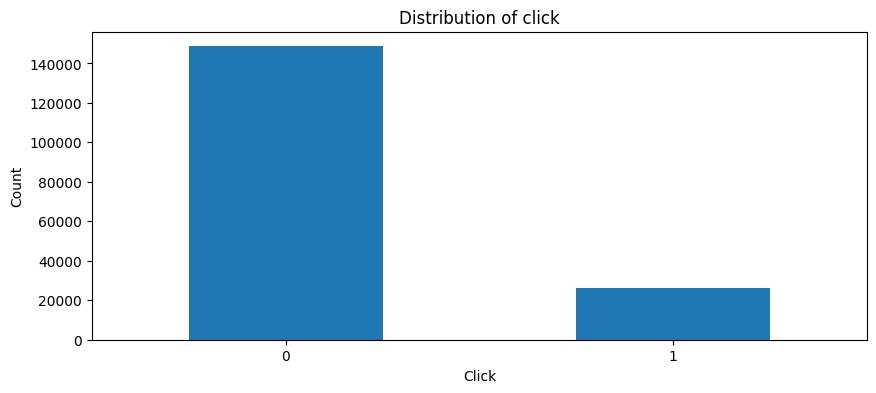

click
0    148629
1     26129
Name: count, dtype: int64
Imbalance ratio: 5.69
Click through rate all dataset: 0.15


In [18]:
# Plotting the distribution of the target
plt.figure(figsize=(10, 4))
y.value_counts().plot(kind='bar')  
plt.xlabel('Click')
plt.ylabel('Count')
plt.title(f'Distribution of {y.name}')
plt.xticks(rotation=0)  # Rotate x labels by 0 degrees
plt.show()

# Examine imbalance in the target variable 'click'
print(y.value_counts())
imbalance_ratio = y.value_counts()[0] / y.value_counts()[1]
print(f'Imbalance ratio: {imbalance_ratio:.2f}')

# Click thorugh rate
CTR = y.mean()
print(f'Click through rate all dataset: {CTR:.2f}')

### Distribution of Features (<4000 unique values)

In [19]:
# Filtering features with less than 4000 unique values
categorical_features_few_categories = []

for column in x:
    if x[column].nunique() < 4000:
        categorical_features_few_categories.append(column)
        print (column, x[column].nunique())

C1 7
banner_pos 5
site_id 1313
site_domain 2047
site_category 5
app_id 1841
app_domain 172
app_category 25
device_type 4
device_conn_type 4
C14 1833
C15 8
C16 9
C17 344
C18 4
C19 60
C20 156
C21 58
date 10
day_of_week 7
hour 24
num_impressions_user_day 46
time_interval_last_visit 224
num_days_user_appears 10
num_previous_clicks 408


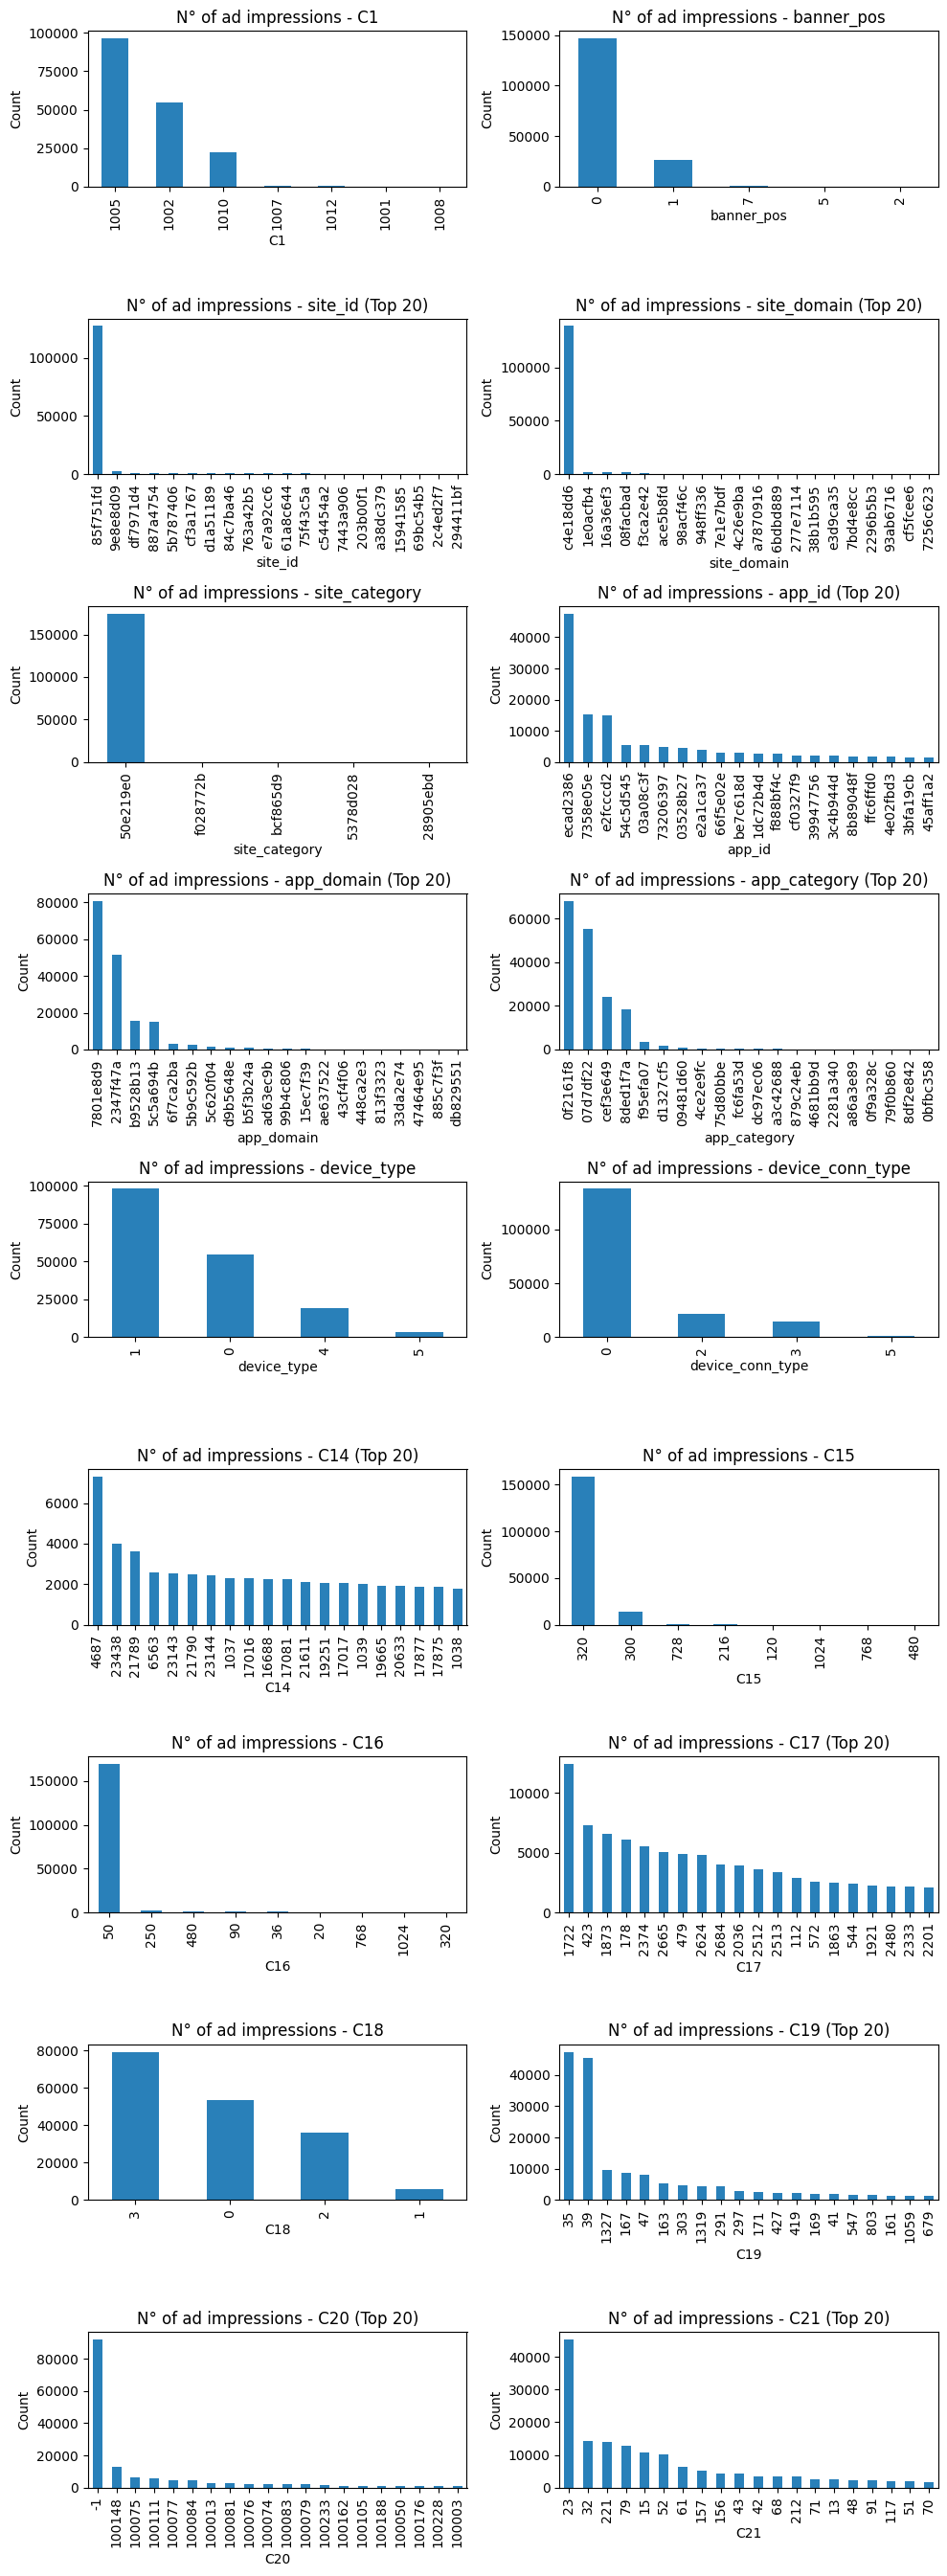

In [20]:
import matplotlib.pyplot as plt

# Exclude date, day_of_week, and hour
excluded_features = ['date', 'day_of_week', 'hour', 'device_id', 'num_impressions_user_day', 'time_interval_last_visit', 'num_days_user_appears', 'num_previous_clicks']
categorical_features_few_categories = [feature for feature in categorical_features_few_categories if feature not in excluded_features]

# Set the threshold for significant categories
significant_threshold = 20

# Calculate number of rows needed
num_features = len(categorical_features_few_categories)
num_rows = (num_features + 1) // 2  # Add 1 to round up if num_features is odd

# Create subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(10, num_rows * 3))

# Iterate over each categorical feature
for i, feature in enumerate(categorical_features_few_categories):
    row, col = divmod(i, 2)  # Calculate subplot indices

    # Count occurrences of each category
    category_counts = df[feature].value_counts()

    # Sort categories by count
    sorted_categories = category_counts.sort_values(ascending=False)

    # Check if the number of categories exceeds the threshold
    if len(sorted_categories) > significant_threshold:
        # Plot only the most significant categories
        top_categories = sorted_categories[:significant_threshold]
        top_categories.plot(kind='bar', ax=axes[row, col], color='#2980B9')
        axes[row, col].set_title(f'N° of ad impressions - {feature} (Top {significant_threshold})')
    else:
        # Plot all categories
        sorted_categories.plot(kind='bar', ax=axes[row, col], color='#2980B9')
        axes[row, col].set_title(f'N° of ad impressions - {feature}')

    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Count')
    axes[row, col].tick_params(axis='x', rotation=90)

# Hide any unused subplots
for i in range(num_features, num_rows * 2):
    row, col = divmod(i, 2)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


#### Comments about N° of ad impressions barplots:
C1, banner_pos, site_category, app_domain, app_category, device_type, device_conn_type, C15, C16, C19, C20 have few categories that concentrate most of the datapoints (ad impressions)

C18, C21, day_of_week, hour have the ads impressions more evenly distributed among their categories.

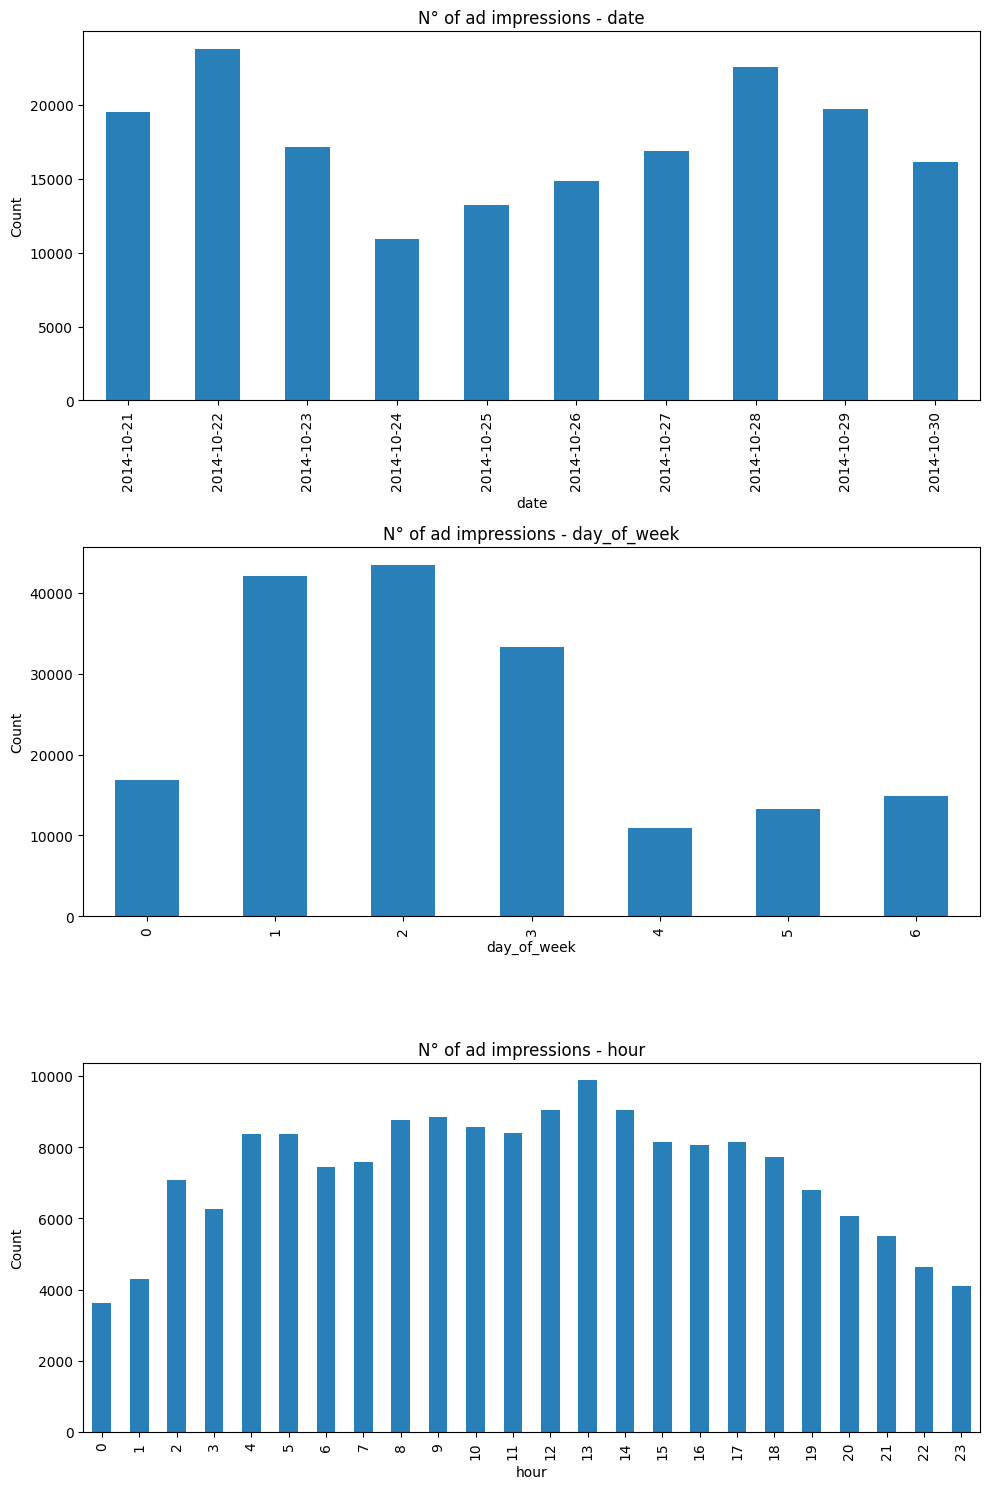

In [21]:
import matplotlib.pyplot as plt

# Features to include
included_features = ['date', 'day_of_week', 'hour']

# Set the threshold for significant categories
significant_threshold = 20

# Create subplots
fig, axes = plt.subplots(len(included_features), 1, figsize=(10, len(included_features) * 5))

# Iterate over each categorical feature
for i, feature in enumerate(included_features):
    # Count occurrences of each category
    category_counts = df[feature].value_counts()

    # Sort categories by count
    sorted_categories = category_counts.sort_index()

    # Plot the categories in ascending order
    sorted_categories.plot(kind='bar', ax=axes[i], color='#2980B9')
    axes[i].set_title(f'N° of ad impressions - {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

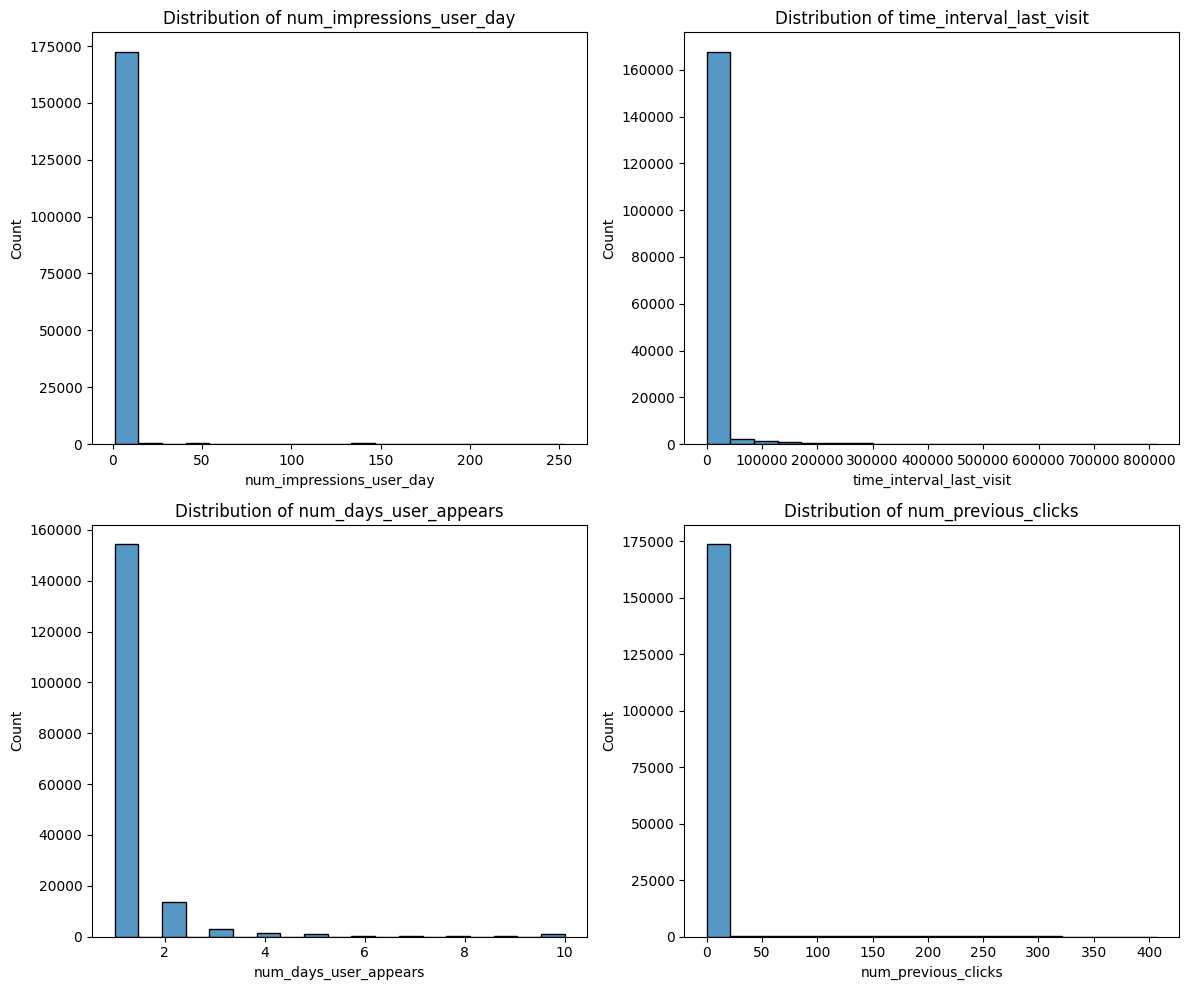

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure and axis
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot distribution of 'num_impressions_user_day'
sns.histplot(df['num_impressions_user_day'], ax=axes[0, 0])
axes[0, 0].set_title('Distribution of num_impressions_user_day')

# Plot distribution of 'time_interval_last_visit'
sns.histplot(df['time_interval_last_visit'], ax=axes[0, 1])
axes[0, 1].set_title('Distribution of time_interval_last_visit')

# Plot distribution of 'num_days_user_appears'
sns.histplot(df['num_days_user_appears'], ax=axes[1, 0])
axes[1, 0].set_title('Distribution of num_days_user_appears')

# Plot distribution of 'num_previous_clicks'
sns.histplot(df['num_previous_clicks'], ax=axes[1, 1])
axes[1, 1].set_title('Distribution of num_previous_clicks')

plt.tight_layout()
plt.show()

### Plotting CTR view per Feature

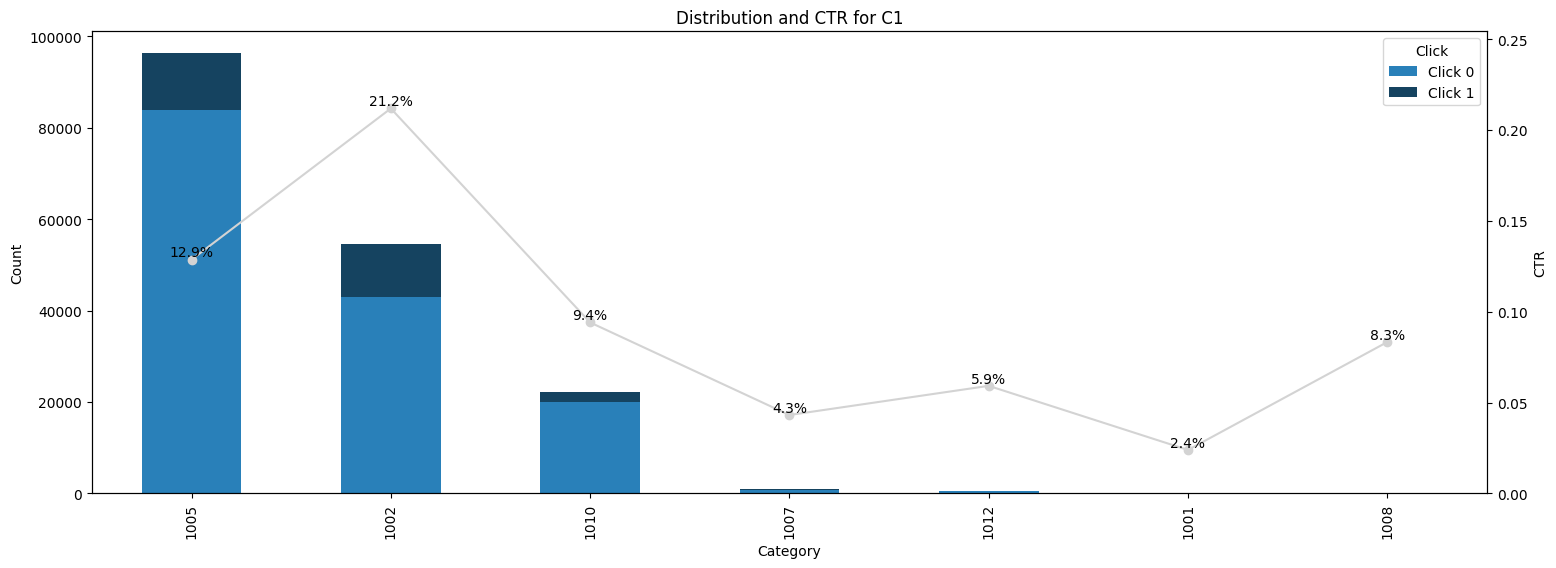


Feature: C1
Category: 1005, Rows: 96273, Clicks: 12393, CTR: 12.87%
Category: 1002, Rows: 54569, Clicks: 11563, CTR: 21.19%
Category: 1010, Rows: 22151, Clicks: 2085, CTR: 9.41%
Category: 1007, Rows: 880, Clicks: 38, CTR: 4.32%
Category: 1012, Rows: 574, Clicks: 34, CTR: 5.92%
Category: 1001, Rows: 167, Clicks: 4, CTR: 2.40%
Category: 1008, Rows: 144, Clicks: 12, CTR: 8.33%


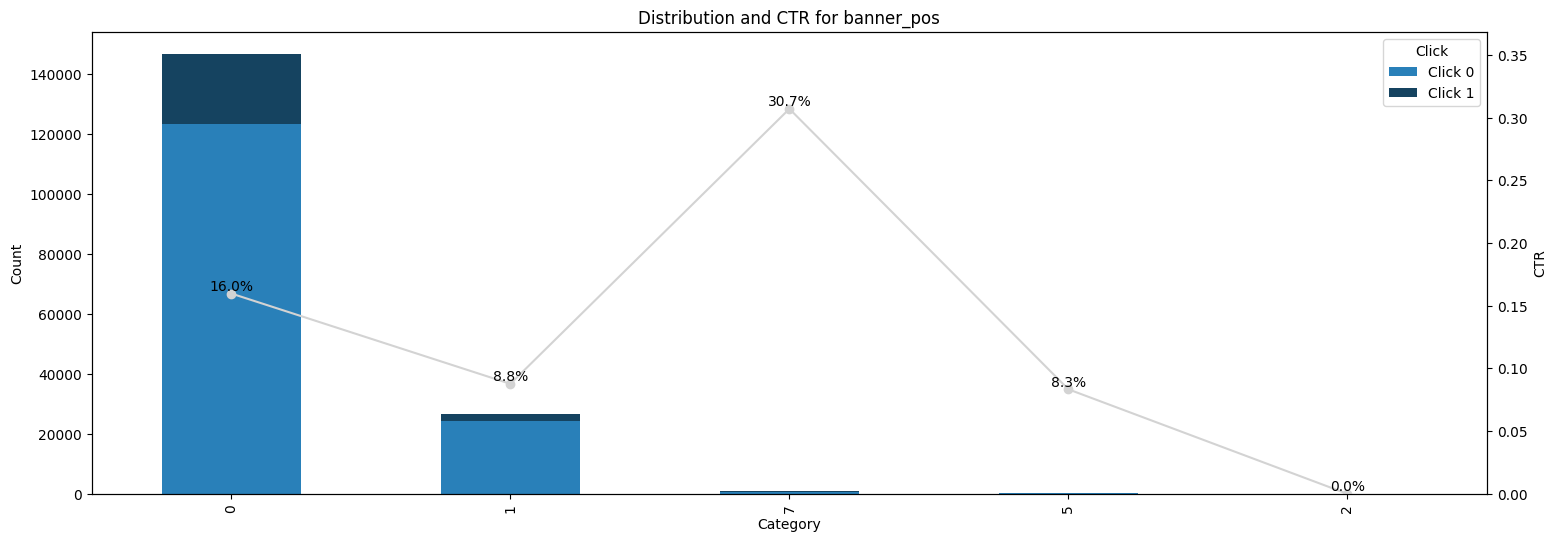


Feature: banner_pos
Category: 0, Rows: 146773, Clicks: 23435, CTR: 15.97%
Category: 1, Rows: 26742, Clicks: 2345, CTR: 8.77%
Category: 7, Rows: 1098, Clicks: 337, CTR: 30.69%
Category: 5, Rows: 144, Clicks: 12, CTR: 8.33%
Category: 2, Rows: 1, Clicks: 0, CTR: 0.00%


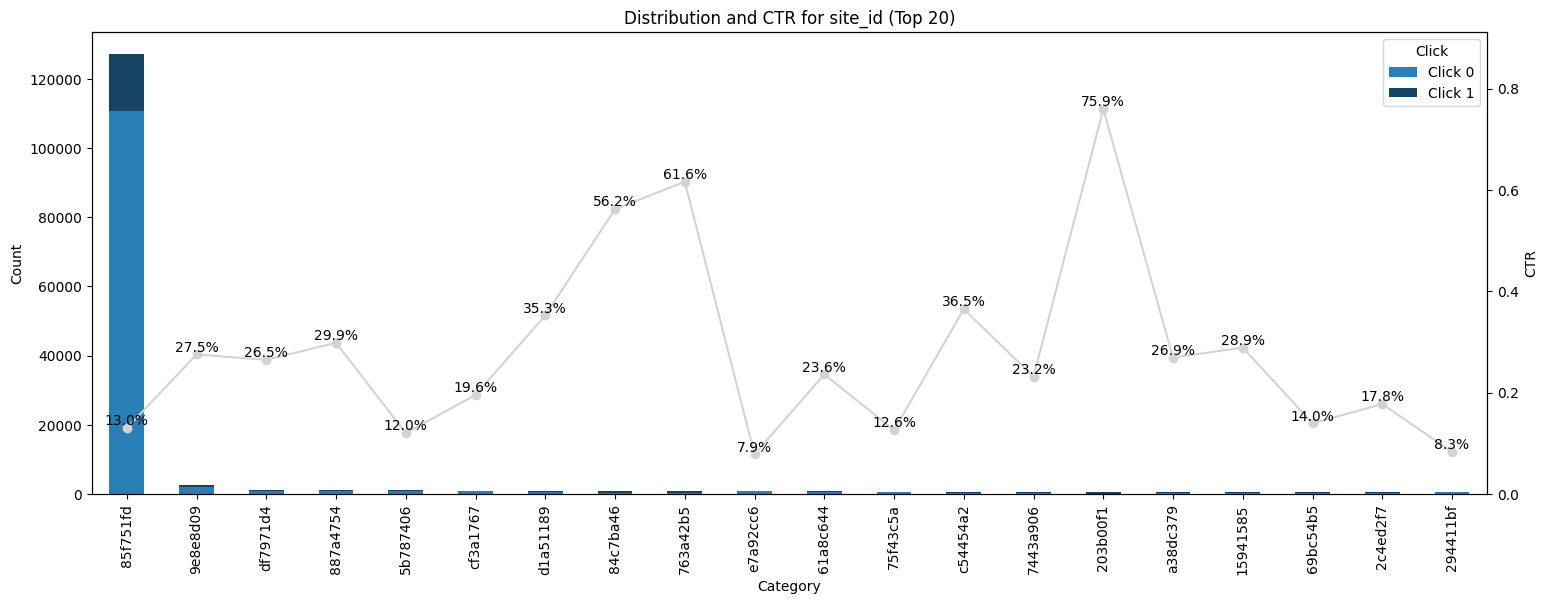


Feature: site_id
Category: 85f751fd, Rows: 127160, Clicks: 16518, CTR: 12.99%
Category: 9e8e8d09, Rows: 2643, Clicks: 728, CTR: 27.54%
Category: df7971d4, Rows: 1193, Clicks: 316, CTR: 26.49%
Category: 887a4754, Rows: 1072, Clicks: 320, CTR: 29.85%
Category: 5b787406, Rows: 1047, Clicks: 126, CTR: 12.03%
Category: cf3a1767, Rows: 992, Clicks: 194, CTR: 19.56%
Category: d1a51189, Rows: 902, Clicks: 318, CTR: 35.25%
Category: 84c7ba46, Rows: 863, Clicks: 485, CTR: 56.20%
Category: 763a42b5, Rows: 831, Clicks: 512, CTR: 61.61%
Category: e7a92cc6, Rows: 815, Clicks: 64, CTR: 7.85%
Category: 61a8c644, Rows: 758, Clicks: 179, CTR: 23.61%
Category: 75f43c5a, Rows: 738, Clicks: 93, CTR: 12.60%
Category: c54454a2, Rows: 625, Clicks: 228, CTR: 36.48%
Category: 7443a906, Rows: 578, Clicks: 134, CTR: 23.18%
Category: 203b00f1, Rows: 557, Clicks: 423, CTR: 75.94%
Category: a38dc379, Rows: 542, Clicks: 146, CTR: 26.94%
Category: 15941585, Rows: 540, Clicks: 156, CTR: 28.89%
Category: 69bc54b5, Rows

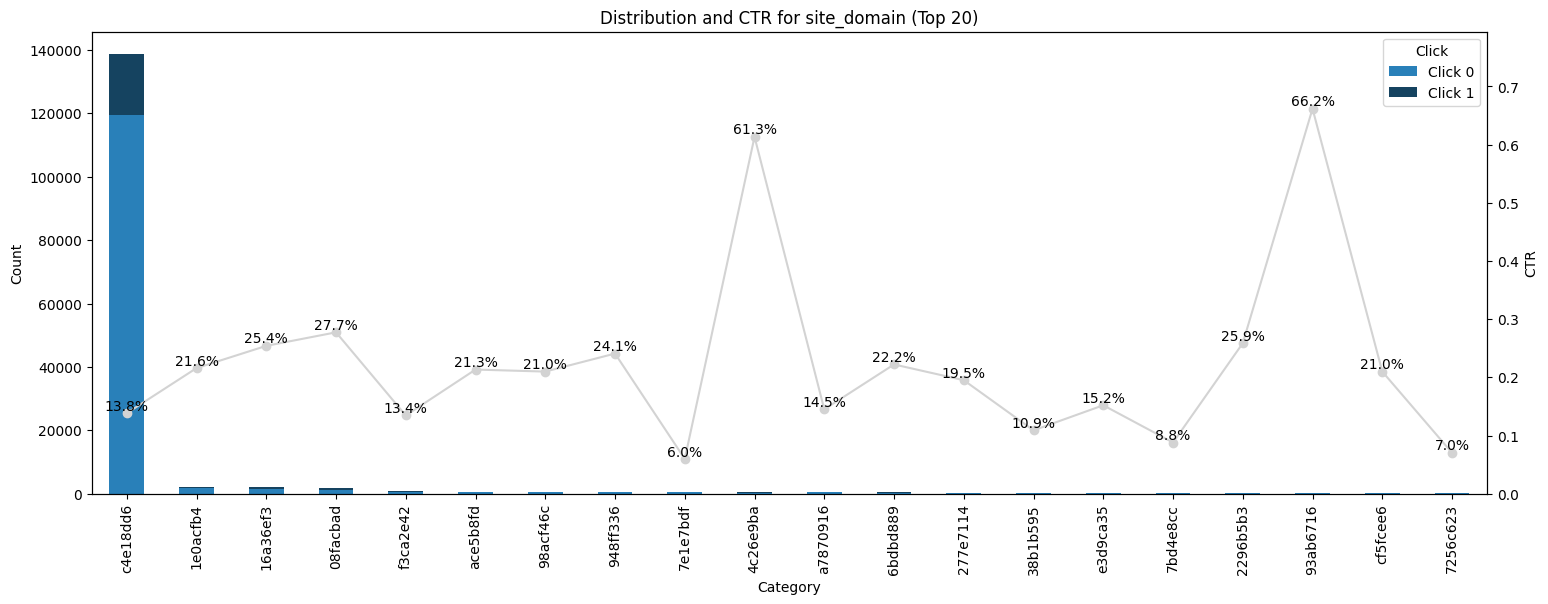


Feature: site_domain
Category: c4e18dd6, Rows: 138807, Clicks: 19218, CTR: 13.85%
Category: 1e0acfb4, Rows: 2260, Clicks: 488, CTR: 21.59%
Category: 16a36ef3, Rows: 1979, Clicks: 503, CTR: 25.42%
Category: 08facbad, Rows: 1723, Clicks: 478, CTR: 27.74%
Category: f3ca2e42, Rows: 766, Clicks: 103, CTR: 13.45%
Category: ace5b8fd, Rows: 656, Clicks: 140, CTR: 21.34%
Category: 98acf46c, Rows: 624, Clicks: 131, CTR: 20.99%
Category: 948ff336, Rows: 606, Clicks: 146, CTR: 24.09%
Category: 7e1e7bdf, Rows: 602, Clicks: 36, CTR: 5.98%
Category: 4c26e9ba, Rows: 520, Clicks: 319, CTR: 61.35%
Category: a7870916, Rows: 476, Clicks: 69, CTR: 14.50%
Category: 6bdbd889, Rows: 405, Clicks: 90, CTR: 22.22%
Category: 277e7114, Rows: 369, Clicks: 72, CTR: 19.51%
Category: 38b1b595, Rows: 358, Clicks: 39, CTR: 10.89%
Category: e3d9ca35, Rows: 342, Clicks: 52, CTR: 15.20%
Category: 7bd4e8cc, Rows: 307, Clicks: 27, CTR: 8.79%
Category: 2296b5b3, Rows: 286, Clicks: 74, CTR: 25.87%
Category: 93ab6716, Rows: 27

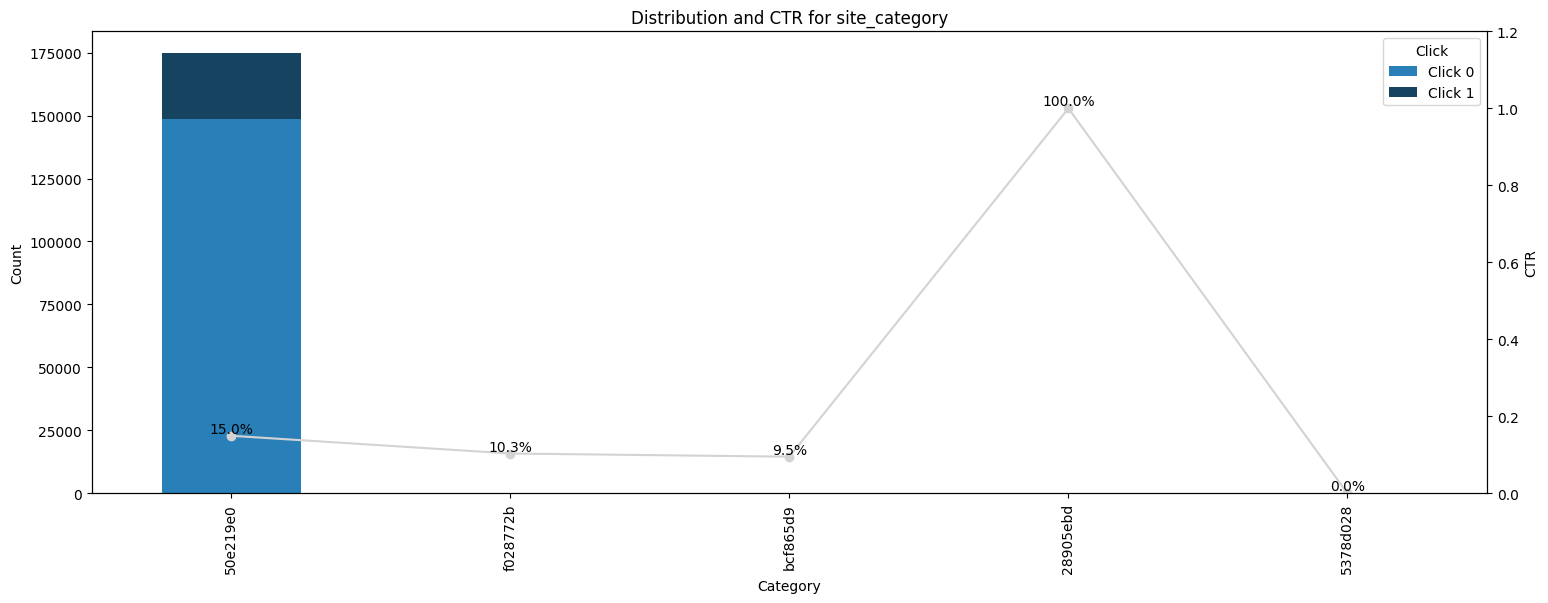


Feature: site_category
Category: 50e219e0, Rows: 174704, Clicks: 26122, CTR: 14.95%
Category: f028772b, Rows: 29, Clicks: 3, CTR: 10.34%
Category: bcf865d9, Rows: 21, Clicks: 2, CTR: 9.52%
Category: 28905ebd, Rows: 2, Clicks: 2, CTR: 100.00%
Category: 5378d028, Rows: 2, Clicks: 0, CTR: 0.00%


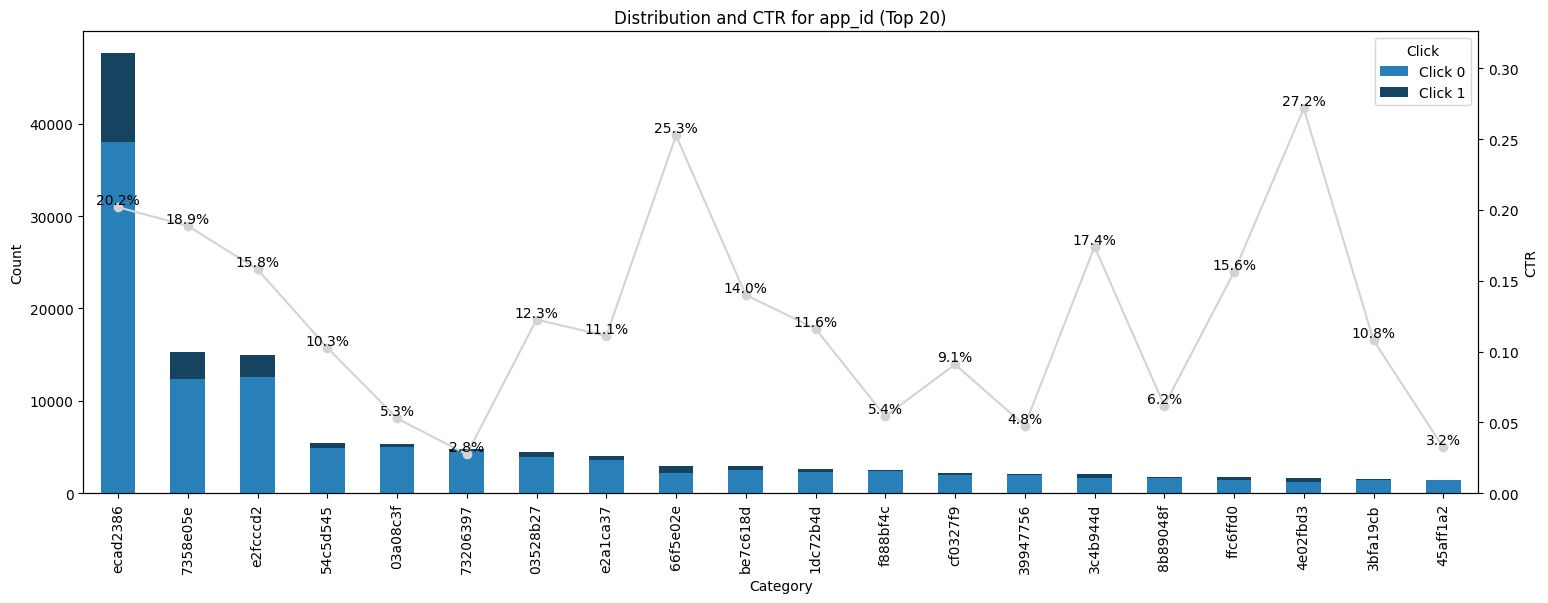


Feature: app_id
Category: ecad2386, Rows: 47598, Clicks: 9611, CTR: 20.19%
Category: 7358e05e, Rows: 15274, Clicks: 2883, CTR: 18.88%
Category: e2fcccd2, Rows: 15011, Clicks: 2372, CTR: 15.80%
Category: 54c5d545, Rows: 5466, Clicks: 562, CTR: 10.28%
Category: 03a08c3f, Rows: 5309, Clicks: 281, CTR: 5.29%
Category: 73206397, Rows: 4762, Clicks: 131, CTR: 2.75%
Category: 03528b27, Rows: 4509, Clicks: 553, CTR: 12.26%
Category: e2a1ca37, Rows: 4026, Clicks: 447, CTR: 11.10%
Category: 66f5e02e, Rows: 3001, Clicks: 758, CTR: 25.26%
Category: be7c618d, Rows: 2908, Clicks: 407, CTR: 14.00%
Category: 1dc72b4d, Rows: 2600, Clicks: 302, CTR: 11.62%
Category: f888bf4c, Rows: 2577, Clicks: 140, CTR: 5.43%
Category: cf0327f9, Rows: 2176, Clicks: 198, CTR: 9.10%
Category: 39947756, Rows: 2092, Clicks: 100, CTR: 4.78%
Category: 3c4b944d, Rows: 2044, Clicks: 356, CTR: 17.42%
Category: 8b89048f, Rows: 1810, Clicks: 112, CTR: 6.19%
Category: ffc6ffd0, Rows: 1761, Clicks: 275, CTR: 15.62%
Category: 4e02

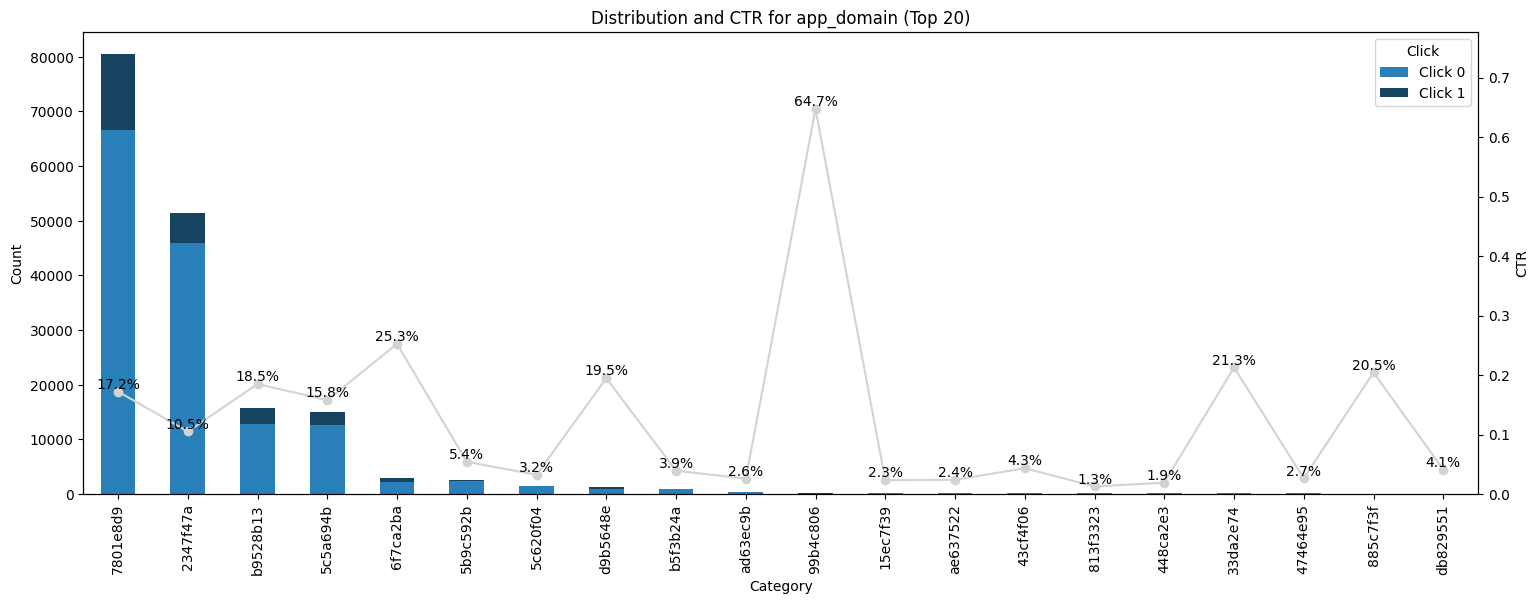


Feature: app_domain
Category: 7801e8d9, Rows: 80494, Clicks: 13880, CTR: 17.24%
Category: 2347f47a, Rows: 51377, Clicks: 5409, CTR: 10.53%
Category: b9528b13, Rows: 15700, Clicks: 2906, CTR: 18.51%
Category: 5c5a694b, Rows: 15015, Clicks: 2372, CTR: 15.80%
Category: 6f7ca2ba, Rows: 3001, Clicks: 758, CTR: 25.26%
Category: 5b9c592b, Rows: 2577, Clicks: 140, CTR: 5.43%
Category: 5c620f04, Rows: 1451, Clicks: 47, CTR: 3.24%
Category: d9b5648e, Rows: 1222, Clicks: 238, CTR: 19.48%
Category: b5f3b24a, Rows: 889, Clicks: 35, CTR: 3.94%
Category: ad63ec9b, Rows: 385, Clicks: 10, CTR: 2.60%
Category: 99b4c806, Rows: 258, Clicks: 167, CTR: 64.73%
Category: 15ec7f39, Rows: 257, Clicks: 6, CTR: 2.33%
Category: ae637522, Rows: 208, Clicks: 5, CTR: 2.40%
Category: 43cf4f06, Rows: 161, Clicks: 7, CTR: 4.35%
Category: 813f3323, Rows: 156, Clicks: 2, CTR: 1.28%
Category: 448ca2e3, Rows: 156, Clicks: 3, CTR: 1.92%
Category: 33da2e74, Rows: 155, Clicks: 33, CTR: 21.29%
Category: 47464e95, Rows: 113, Cl

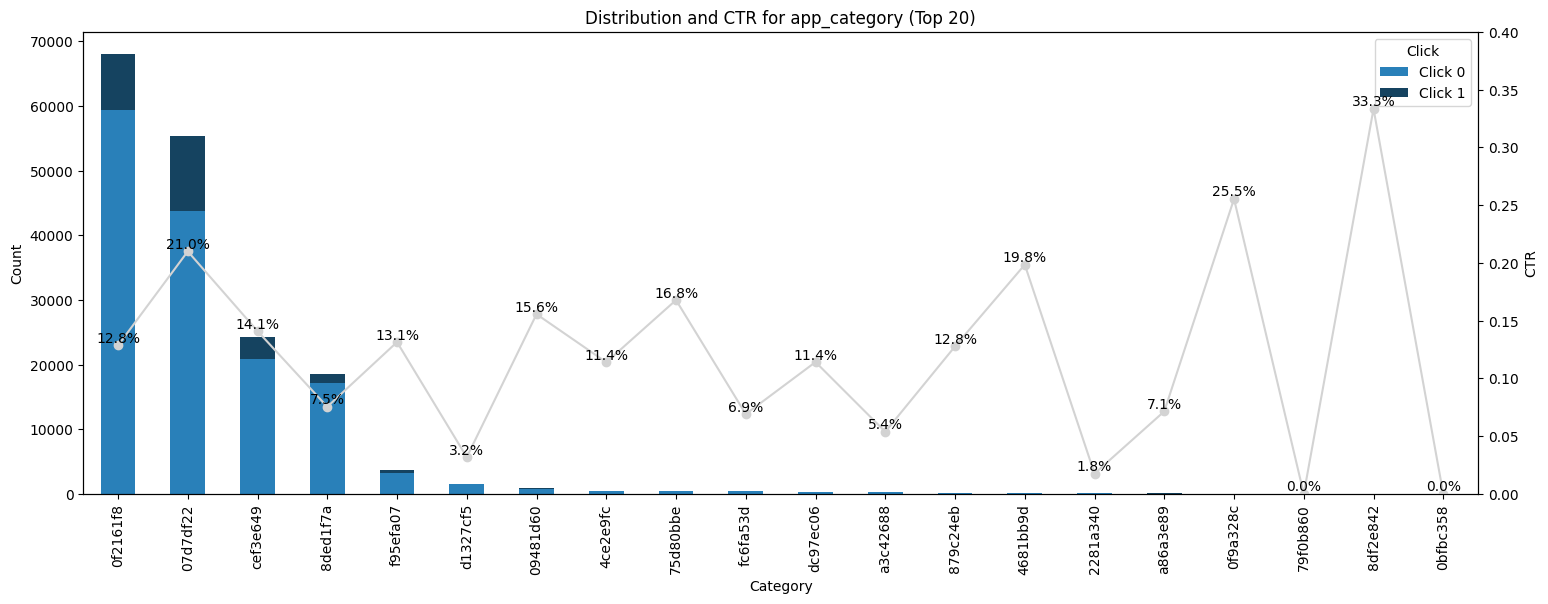


Feature: app_category
Category: 0f2161f8, Rows: 68050, Clicks: 8742, CTR: 12.85%
Category: 07d7df22, Rows: 55344, Clicks: 11619, CTR: 20.99%
Category: cef3e649, Rows: 24259, Clicks: 3418, CTR: 14.09%
Category: 8ded1f7a, Rows: 18529, Clicks: 1397, CTR: 7.54%
Category: f95efa07, Rows: 3676, Clicks: 483, CTR: 13.14%
Category: d1327cf5, Rows: 1543, Clicks: 49, CTR: 3.18%
Category: 09481d60, Rows: 945, Clicks: 147, CTR: 15.56%
Category: 4ce2e9fc, Rows: 474, Clicks: 54, CTR: 11.39%
Category: 75d80bbe, Rows: 447, Clicks: 75, CTR: 16.78%
Category: fc6fa53d, Rows: 391, Clicks: 27, CTR: 6.91%
Category: dc97ec06, Rows: 333, Clicks: 38, CTR: 11.41%
Category: a3c42688, Rows: 279, Clicks: 15, CTR: 5.38%
Category: 879c24eb, Rows: 141, Clicks: 18, CTR: 12.77%
Category: 4681bb9d, Rows: 126, Clicks: 25, CTR: 19.84%
Category: 2281a340, Rows: 57, Clicks: 1, CTR: 1.75%
Category: a86a3e89, Rows: 56, Clicks: 4, CTR: 7.14%
Category: 0f9a328c, Rows: 47, Clicks: 12, CTR: 25.53%
Category: 79f0b860, Rows: 16, Cl

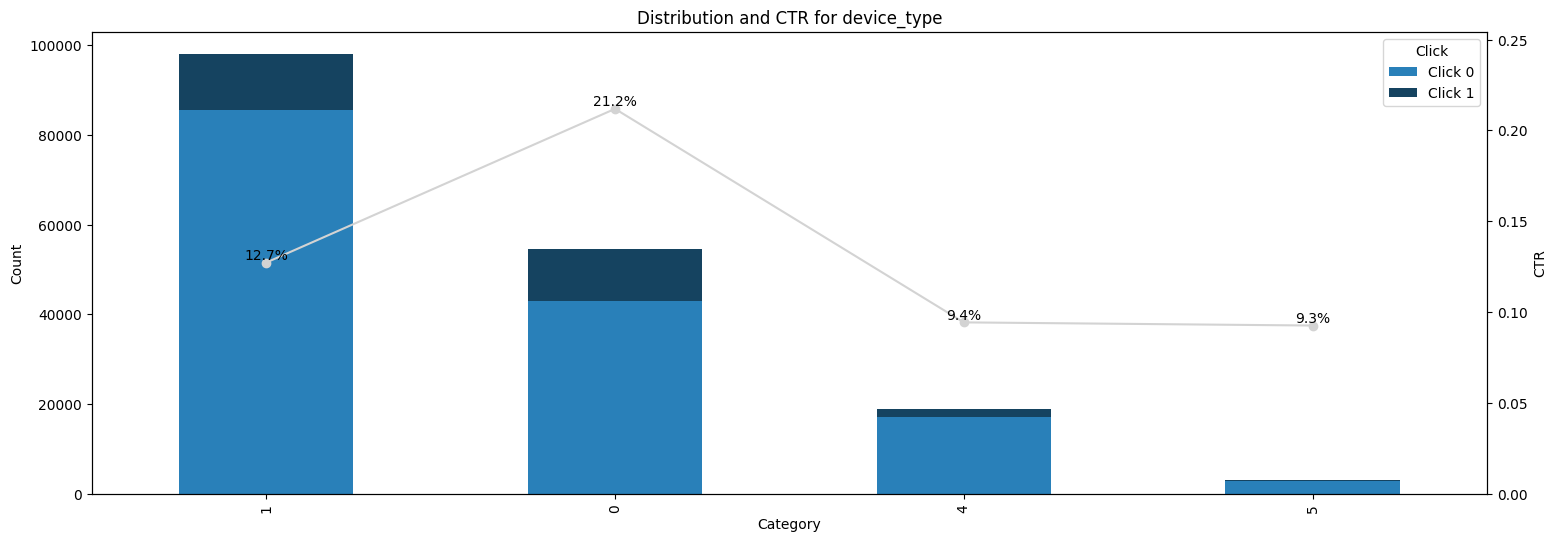


Feature: device_type
Category: 1, Rows: 98038, Clicks: 12481, CTR: 12.73%
Category: 0, Rows: 54569, Clicks: 11563, CTR: 21.19%
Category: 4, Rows: 18999, Clicks: 1793, CTR: 9.44%
Category: 5, Rows: 3152, Clicks: 292, CTR: 9.26%


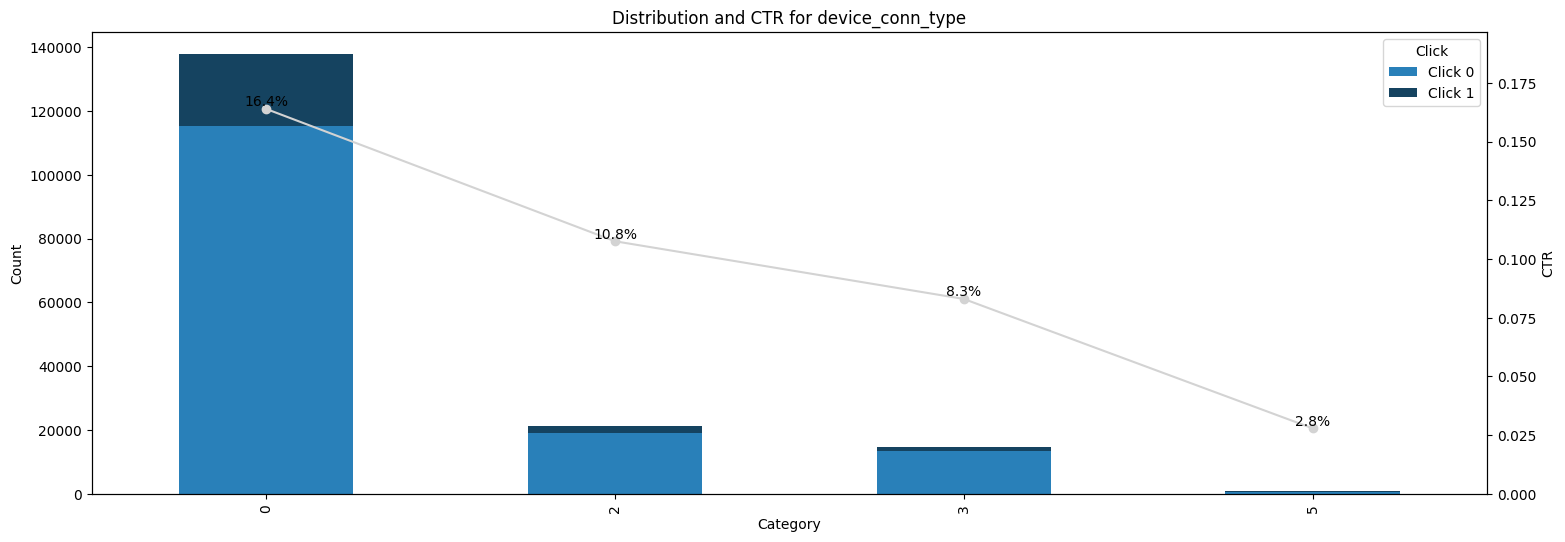


Feature: device_conn_type
Category: 0, Rows: 137819, Clicks: 22582, CTR: 16.39%
Category: 2, Rows: 21357, Clicks: 2297, CTR: 10.76%
Category: 3, Rows: 14795, Clicks: 1228, CTR: 8.30%
Category: 5, Rows: 787, Clicks: 22, CTR: 2.80%


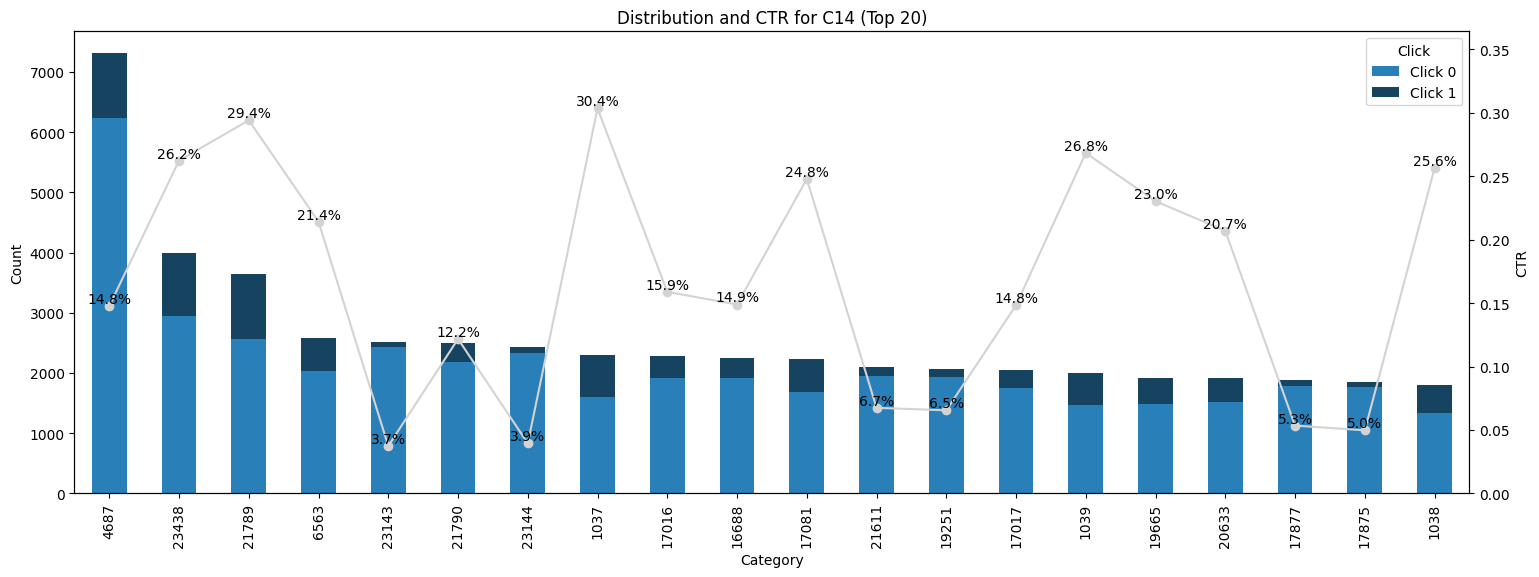


Feature: C14
Category: 4687, Rows: 7308, Clicks: 1079, CTR: 14.76%
Category: 23438, Rows: 3998, Clicks: 1049, CTR: 26.24%
Category: 21789, Rows: 3641, Clicks: 1071, CTR: 29.41%
Category: 6563, Rows: 2577, Clicks: 552, CTR: 21.42%
Category: 23143, Rows: 2517, Clicks: 94, CTR: 3.73%
Category: 21790, Rows: 2489, Clicks: 303, CTR: 12.17%
Category: 23144, Rows: 2433, Clicks: 96, CTR: 3.95%
Category: 1037, Rows: 2306, Clicks: 700, CTR: 30.36%
Category: 17016, Rows: 2285, Clicks: 363, CTR: 15.89%
Category: 16688, Rows: 2250, Clicks: 335, CTR: 14.89%
Category: 17081, Rows: 2231, Clicks: 553, CTR: 24.79%
Category: 21611, Rows: 2091, Clicks: 141, CTR: 6.74%
Category: 19251, Rows: 2063, Clicks: 135, CTR: 6.54%
Category: 17017, Rows: 2050, Clicks: 304, CTR: 14.83%
Category: 1039, Rows: 2001, Clicks: 537, CTR: 26.84%
Category: 19665, Rows: 1919, Clicks: 442, CTR: 23.03%
Category: 20633, Rows: 1918, Clicks: 397, CTR: 20.70%
Category: 17877, Rows: 1890, Clicks: 101, CTR: 5.34%
Category: 17875, Rows:

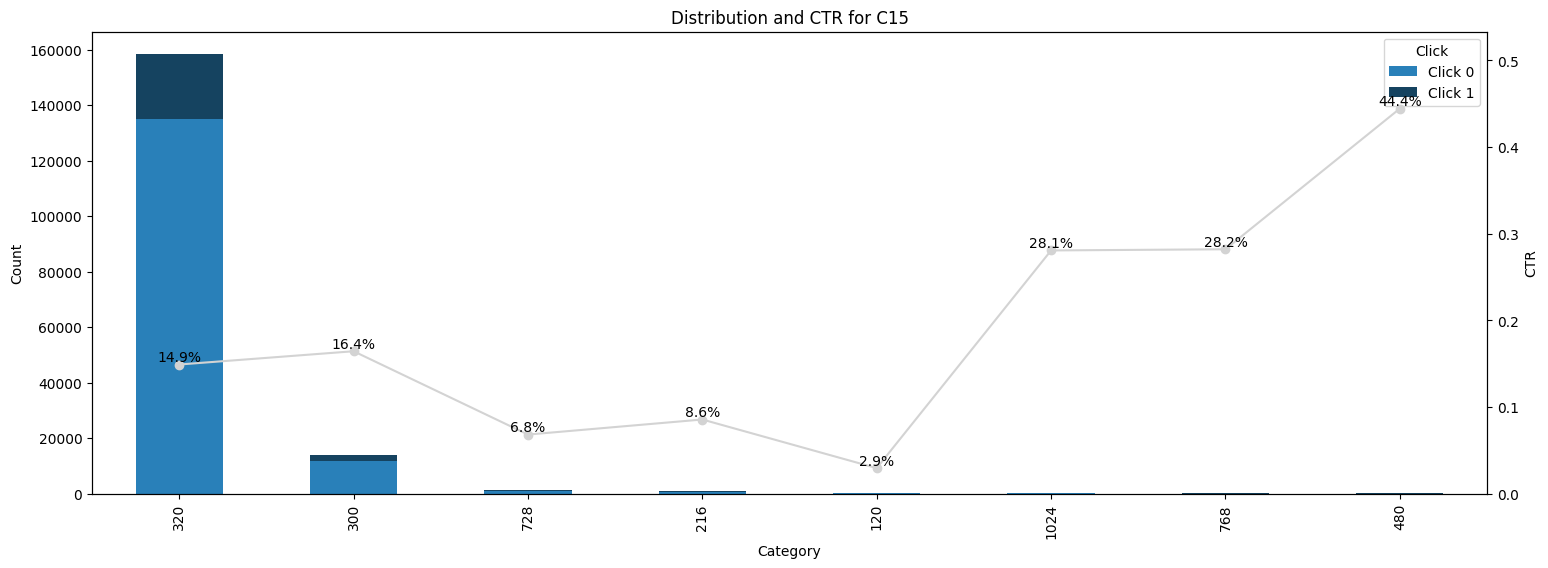


Feature: C15
Category: 320, Rows: 158625, Clicks: 23637, CTR: 14.90%
Category: 300, Rows: 14008, Clicks: 2302, CTR: 16.43%
Category: 728, Rows: 1130, Clicks: 77, CTR: 6.81%
Category: 216, Rows: 795, Clicks: 68, CTR: 8.55%
Category: 120, Rows: 68, Clicks: 2, CTR: 2.94%
Category: 1024, Rows: 57, Clicks: 16, CTR: 28.07%
Category: 768, Rows: 39, Clicks: 11, CTR: 28.21%
Category: 480, Rows: 36, Clicks: 16, CTR: 44.44%


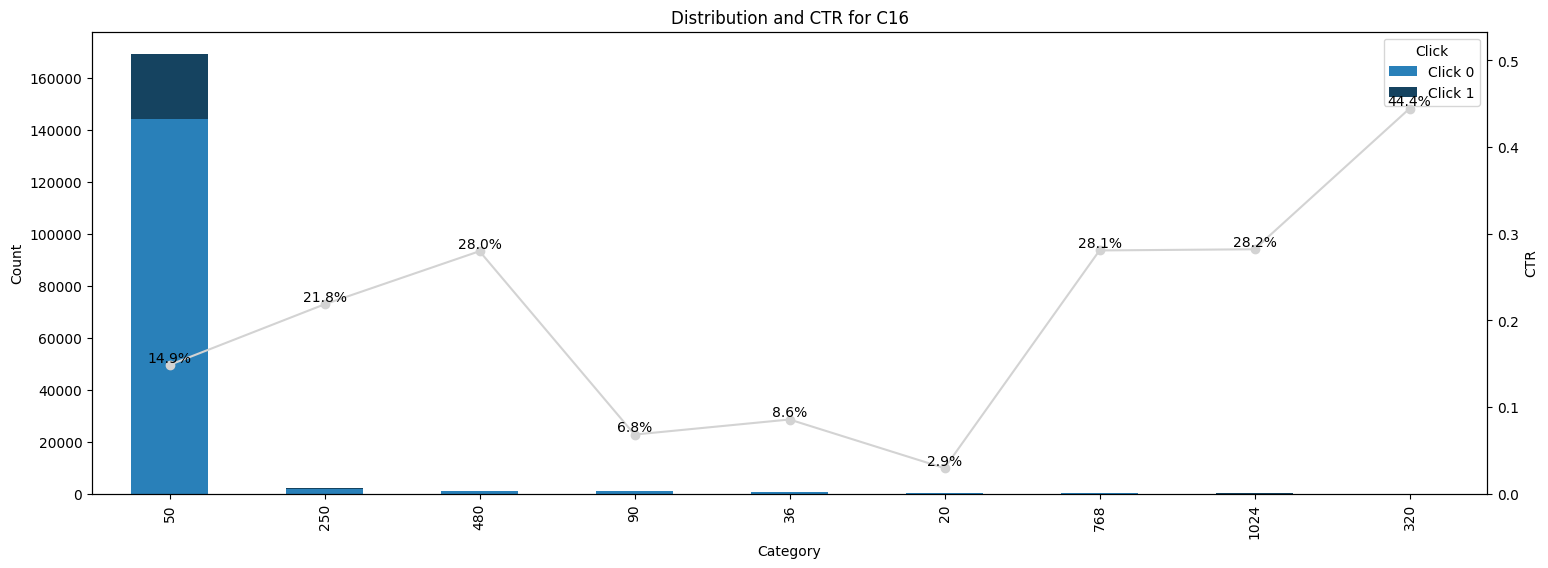


Feature: C16
Category: 50, Rows: 169381, Clicks: 25157, CTR: 14.85%
Category: 250, Rows: 2087, Clicks: 456, CTR: 21.85%
Category: 480, Rows: 1165, Clicks: 326, CTR: 27.98%
Category: 90, Rows: 1130, Clicks: 77, CTR: 6.81%
Category: 36, Rows: 795, Clicks: 68, CTR: 8.55%
Category: 20, Rows: 68, Clicks: 2, CTR: 2.94%
Category: 768, Rows: 57, Clicks: 16, CTR: 28.07%
Category: 1024, Rows: 39, Clicks: 11, CTR: 28.21%
Category: 320, Rows: 36, Clicks: 16, CTR: 44.44%


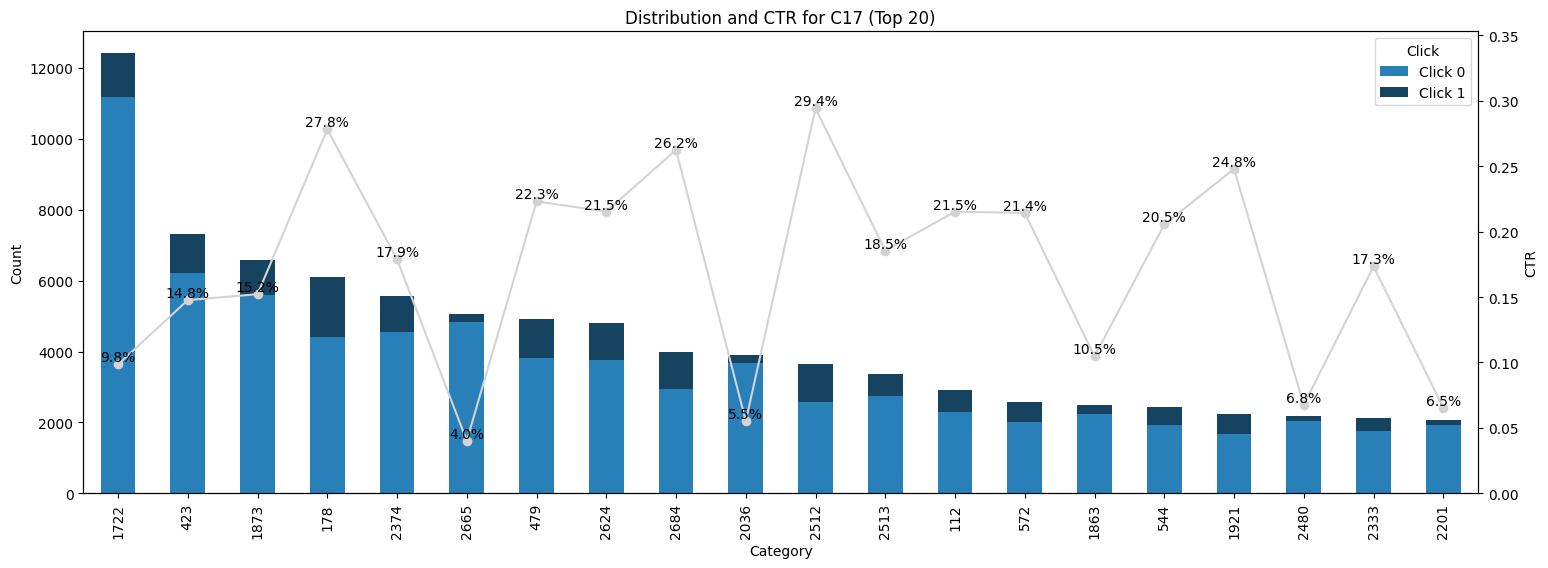


Feature: C17
Category: 1722, Rows: 12413, Clicks: 1222, CTR: 9.84%
Category: 423, Rows: 7308, Clicks: 1079, CTR: 14.76%
Category: 1873, Rows: 6585, Clicks: 1002, CTR: 15.22%
Category: 178, Rows: 6106, Clicks: 1698, CTR: 27.81%
Category: 2374, Rows: 5559, Clicks: 994, CTR: 17.88%
Category: 2665, Rows: 5047, Clicks: 203, CTR: 4.02%
Category: 479, Rows: 4931, Clicks: 1100, CTR: 22.31%
Category: 2624, Rows: 4794, Clicks: 1032, CTR: 21.53%
Category: 2684, Rows: 3998, Clicks: 1049, CTR: 26.24%
Category: 2036, Rows: 3891, Clicks: 215, CTR: 5.53%
Category: 2512, Rows: 3641, Clicks: 1071, CTR: 29.41%
Category: 2513, Rows: 3359, Clicks: 623, CTR: 18.55%
Category: 112, Rows: 2909, Clicks: 626, CTR: 21.52%
Category: 572, Rows: 2577, Clicks: 552, CTR: 21.42%
Category: 1863, Rows: 2485, Clicks: 260, CTR: 10.46%
Category: 544, Rows: 2429, Clicks: 499, CTR: 20.54%
Category: 1921, Rows: 2231, Clicks: 553, CTR: 24.79%
Category: 2480, Rows: 2187, Clicks: 148, CTR: 6.77%
Category: 2333, Rows: 2134, Click

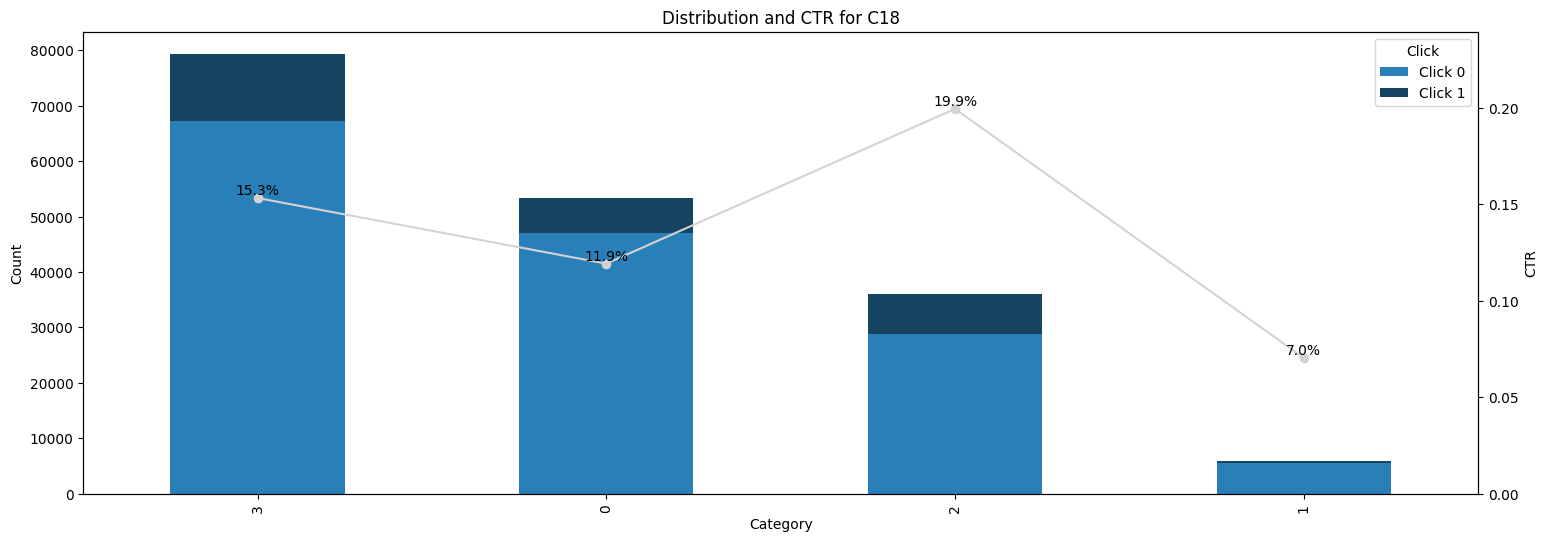


Feature: C18
Category: 3, Rows: 79335, Clicks: 12154, CTR: 15.32%
Category: 0, Rows: 53307, Clicks: 6354, CTR: 11.92%
Category: 2, Rows: 36106, Clicks: 7198, CTR: 19.94%
Category: 1, Rows: 6010, Clicks: 423, CTR: 7.04%


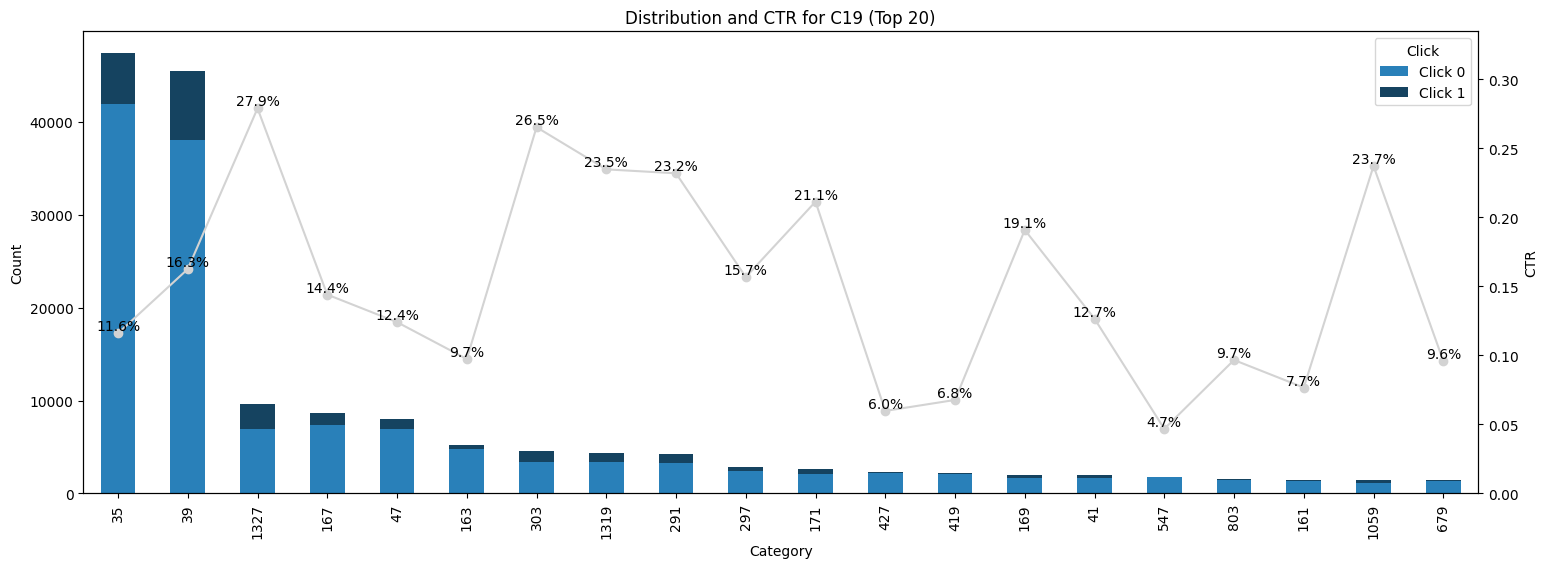


Feature: C19
Category: 35, Rows: 47396, Clicks: 5499, CTR: 11.60%
Category: 39, Rows: 45457, Clicks: 7389, CTR: 16.25%
Category: 1327, Rows: 9576, Clicks: 2672, CTR: 27.90%
Category: 167, Rows: 8637, Clicks: 1244, CTR: 14.40%
Category: 47, Rows: 7971, Clicks: 989, CTR: 12.41%
Category: 163, Rows: 5237, Clicks: 510, CTR: 9.74%
Category: 303, Rows: 4575, Clicks: 1214, CTR: 26.54%
Category: 1319, Rows: 4344, Clicks: 1020, CTR: 23.48%
Category: 291, Rows: 4281, Clicks: 993, CTR: 23.20%
Category: 297, Rows: 2826, Clicks: 443, CTR: 15.68%
Category: 171, Rows: 2611, Clicks: 552, CTR: 21.14%
Category: 427, Rows: 2310, Clicks: 138, CTR: 5.97%
Category: 419, Rows: 2201, Clicks: 149, CTR: 6.77%
Category: 169, Rows: 1980, Clicks: 378, CTR: 19.09%
Category: 41, Rows: 1952, Clicks: 247, CTR: 12.65%
Category: 547, Rows: 1797, Clicks: 84, CTR: 4.67%
Category: 803, Rows: 1542, Clicks: 149, CTR: 9.66%
Category: 161, Rows: 1474, Clicks: 113, CTR: 7.67%
Category: 1059, Rows: 1471, Clicks: 349, CTR: 23.73

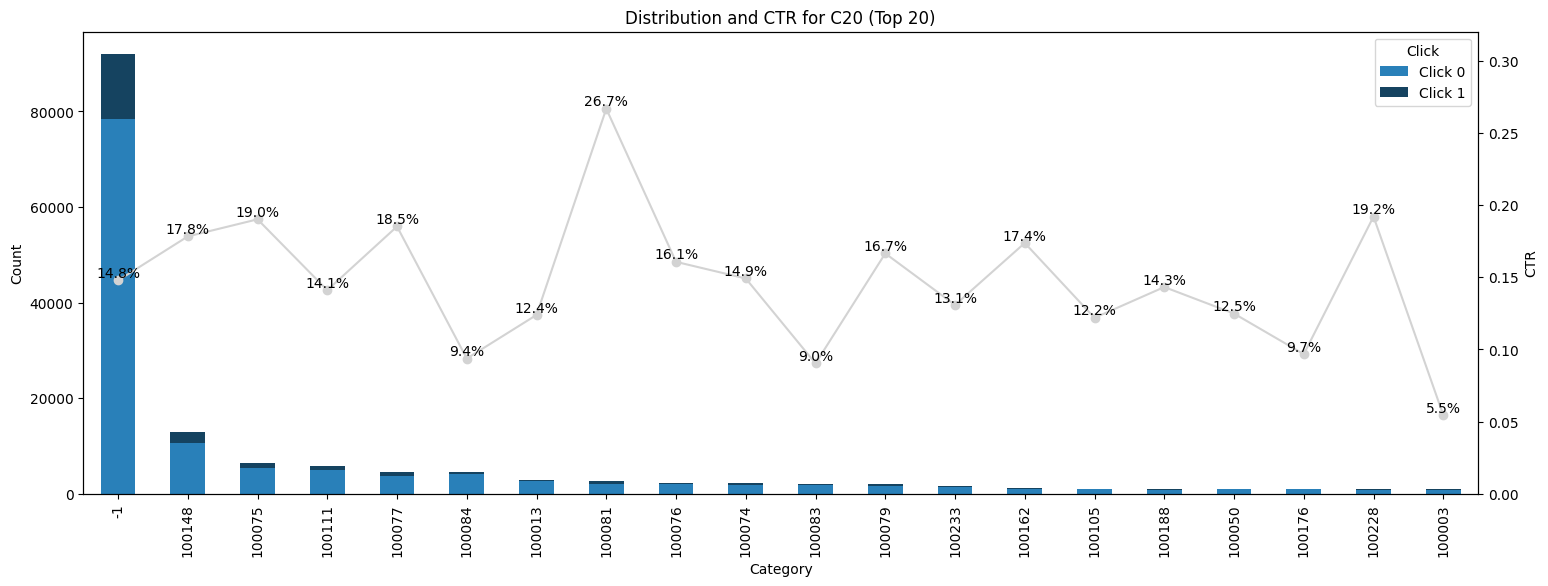


Feature: C20
Category: -1, Rows: 92083, Clicks: 13612, CTR: 14.78%
Category: 100148, Rows: 12990, Clicks: 2317, CTR: 17.84%
Category: 100075, Rows: 6529, Clicks: 1242, CTR: 19.02%
Category: 100111, Rows: 5727, Clicks: 808, CTR: 14.11%
Category: 100077, Rows: 4556, Clicks: 844, CTR: 18.53%
Category: 100084, Rows: 4492, Clicks: 421, CTR: 9.37%
Category: 100013, Rows: 2929, Clicks: 363, CTR: 12.39%
Category: 100081, Rows: 2679, Clicks: 715, CTR: 26.69%
Category: 100076, Rows: 2308, Clicks: 371, CTR: 16.07%
Category: 100074, Rows: 2205, Clicks: 329, CTR: 14.92%
Category: 100083, Rows: 2060, Clicks: 186, CTR: 9.03%
Category: 100079, Rows: 2017, Clicks: 336, CTR: 16.66%
Category: 100233, Rows: 1651, Clicks: 216, CTR: 13.08%
Category: 100162, Rows: 1283, Clicks: 223, CTR: 17.38%
Category: 100105, Rows: 1058, Clicks: 129, CTR: 12.19%
Category: 100188, Rows: 1026, Clicks: 147, CTR: 14.33%
Category: 100050, Rows: 1025, Clicks: 128, CTR: 12.49%
Category: 100176, Rows: 982, Clicks: 95, CTR: 9.67%

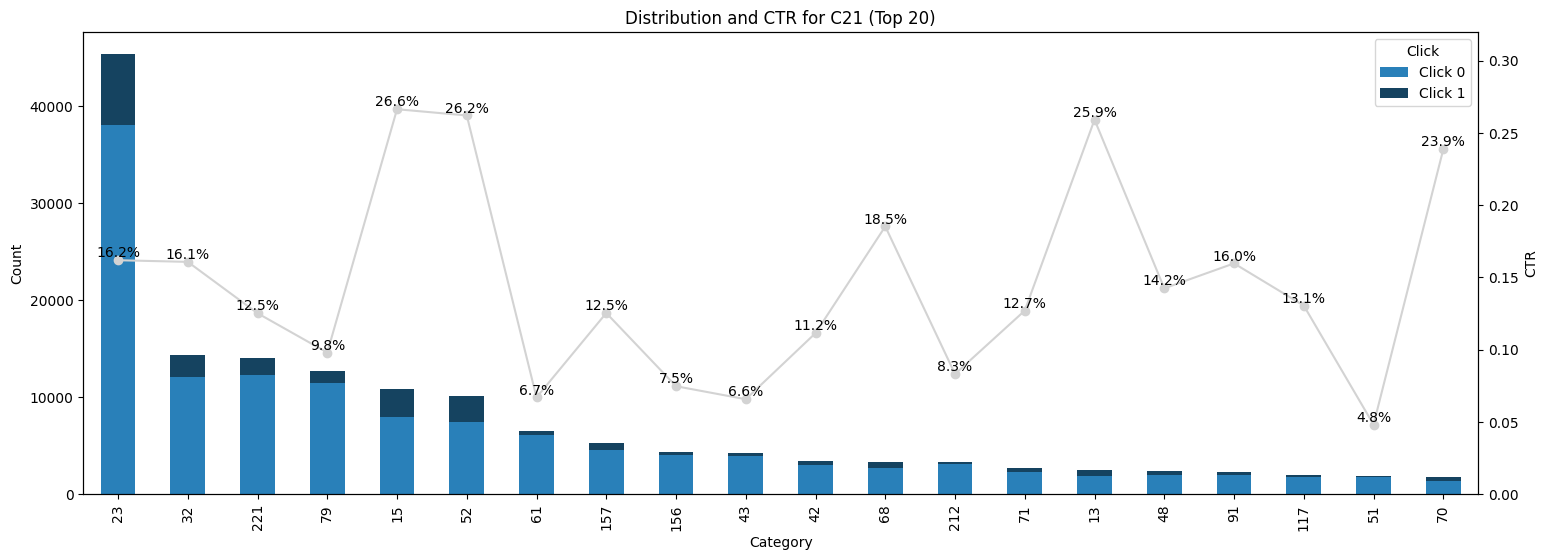


Feature: C21
Category: 23, Rows: 45347, Clicks: 7344, CTR: 16.20%
Category: 32, Rows: 14352, Clicks: 2308, CTR: 16.08%
Category: 221, Rows: 14035, Clicks: 1758, CTR: 12.53%
Category: 79, Rows: 12739, Clicks: 1249, CTR: 9.80%
Category: 15, Rows: 10861, Clicks: 2894, CTR: 26.65%
Category: 52, Rows: 10094, Clicks: 2646, CTR: 26.21%
Category: 61, Rows: 6495, Clicks: 435, CTR: 6.70%
Category: 157, Rows: 5239, Clicks: 657, CTR: 12.54%
Category: 156, Rows: 4361, Clicks: 326, CTR: 7.48%
Category: 43, Rows: 4213, Clicks: 277, CTR: 6.57%
Category: 42, Rows: 3381, Clicks: 377, CTR: 11.15%
Category: 68, Rows: 3367, Clicks: 624, CTR: 18.53%
Category: 212, Rows: 3342, Clicks: 278, CTR: 8.32%
Category: 71, Rows: 2652, Clicks: 337, CTR: 12.71%
Category: 13, Rows: 2469, Clicks: 640, CTR: 25.92%
Category: 48, Rows: 2358, Clicks: 336, CTR: 14.25%
Category: 91, Rows: 2316, Clicks: 370, CTR: 15.98%
Category: 117, Rows: 1999, Clicks: 261, CTR: 13.06%
Category: 51, Rows: 1868, Clicks: 90, CTR: 4.82%
Categor

In [23]:
# Set the threshold for significant categories
significant_threshold = 20

# Iterate over each categorical column
for column in categorical_features_few_categories:
    if column not in ['date', 'day_of_week', 'hour']:
        # Compute the contingency table
        contingency_table = pd.crosstab(df[column], df['click'])

        # Calculate total ad impressions for each category
        total_ad_impressions = contingency_table.sum(axis=1)

        # Sort the contingency table by total ad impressions in descending order
        contingency_table_sorted = contingency_table.loc[total_ad_impressions.sort_values(ascending=False).index]

        # Check if the number of categories exceeds the threshold
        if len(contingency_table_sorted) > significant_threshold:
            # Select only the top 20 categories based on total ad impressions
            contingency_table_sorted = contingency_table_sorted.head(significant_threshold)
            title_suffix = " (Top 20)"
        else:
            title_suffix = ""

        # Calculate CTR for each category using the sorted contingency table
        total_clicks = contingency_table_sorted[1]
        ctr = total_clicks / total_ad_impressions.loc[contingency_table_sorted.index]

        # Plot the bar chart
        fig, ax1 = plt.subplots(figsize=(18, 6))  # Adjust the figsize for wider plots
        contingency_table_sorted.plot(kind='bar', stacked=True, ax=ax1, color=['#2980B9', '#154360'])
        plt.title(f"Distribution and CTR for {column}{title_suffix}")
        plt.xlabel("Category")
        plt.ylabel("Count")
        plt.legend(title='Click', labels=['Click 0', 'Click 1'], loc='upper right')

        # Create a line plot for percentages
        ax2 = ax1.twinx()
        ax2.plot(range(len(ctr)), ctr, marker='o', color='lightgray', label='CTR')

        # Annotate line plot with percentages rounded to one decimal place
        for i, val in enumerate(ctr):
            ax2.text(i, val, f'{val:.1%}', ha='center', va='bottom', color='black')

        # Set the y-axis limits for the line plot
        ax2.set_ylim(0, max(ctr) * 1.2)
        ax2.set_ylabel('CTR')

        # Set the x-axis ticks to be the sorted categories
        ax1.set_xticks(range(len(contingency_table_sorted.index)))
        ax1.set_xticklabels(contingency_table_sorted.index)

        # Show the plot
        plt.show()

        # Print category, number of clicks, CTR, and number of rows for each category
        print(f"\nFeature: {column}")
        for category, clicks, click_rate, num_rows in zip(contingency_table_sorted.index, total_clicks, ctr, total_ad_impressions.loc[contingency_table_sorted.index]):
            print(f"Category: {category}, Rows: {num_rows}, Clicks: {clicks}, CTR: {click_rate:.2%}")

#### Comments related to the AdImpression-CTR barplots per Feature

* C1: Category 1005 might influence predictions since it has the third highest CTR and a significant number ef ad impressions
Category 1002 might also be important, since they have the two highest CTR, however fewer ad impressions.

* banner_pos: The four highest CTR are related to categories of banner_pos 3,4,5,and 7 (CTR above 25%), but have very few ad impressions. 
banner_pos equal to 1 has slightly higher CTR than banner_pos equal to 0 (18.8% > 16.5%)

* site_id: Seems that this feature is going to be significant,
because of the variability of CTR depending on which site_id it is.
For instance, this site_id 5b08c53b has the highest CTR, around 47,7%
and this site_id: e151e245 has also a high CTR (30,17%) and more than 6k rows
which can be significant.

* site_domain: This feature can be redundant with site_id, they are quiet similar in number
of unique values and the trend of CTR is almost the same than site_id. In the modelling part only one of them
will be chosen

* site_category: There are 4 types of site_category having
the highest number of ad impressions, and the site_category 3e814130 has the highest CTR (28,5%

* app_id: most of ad impressions have the same app_id ecad2386, and the CTR is very variable among the next 7 highest app_id categories

* app_category: It is interesting that the app_category that has the highest number of ad impresions
has the second highest number of CTR. Varaibility of CTR among the highest 6 categories of this feature varies from 8 to 25%, 
it is very variable.

* device_model: The category of device_model with highest number of ad impressions
has relatively low CTR compared to the top 13 categories for device_model
The folowing 12 categories don't vary in CTR very much and are around 18-20% of CTR
Also, among the top 20 categories with most ad impressions, 3 of them have very low CTR (2%)

* device_type: most common device_type has 17% of CTR, compared to the device_type with highest CTR, there is not very significant difference (21%)

* device_conn_type: the category 0 has the highest number of datapoints and CTR as well (18%), the second category has around 13% of CTR and the number of rows is almost 10 times less than the 0 category.

* C14: In this case, the variability of CTR is very clear among the different categories of C14.
Varying from 24% for the category with highest number of imoressions to 2% for the third highest.

* C15: The CTR is around 16% for the category 320, which is the one that has most ad impressions.

* C16: The CTR is around 16% for the category 50, which is the one that has most ad impressions.

* C17: In this case, the variability of CTR is very clear too, among the different categories of C17.
Varying from 19% for the category with highest number of imoressions to 2% for the second highest. Even the 13th highest ad impresion category has a very high number of
CTR (almost 40%)

* C18: This feature has 4 categories, and the CTR between first 2 with the highest number of ad impressions
is very similar (around 15%), then for category 2 the CTR is the highest (30%)

* C19: In this case, the variability of CTR is very clear among the different categories of C19.
Varying from 16% for the category with highest number of impressions to 2% for the 4th highest.
Also the category 1063 has a very high CTR , around 37%

* C20: In this case, the variability of CTR is very clear too, among the different categories.
Varying from 19% for the category with highest number of impressions to 2% for some categories among the top 20 with most ad impressions.

* C21: In this case, the variability of CTR is very clear too, among the different categories.
Varying between 3% and 40%.

Probably, the features that have most variability will be the most important predictors (?)

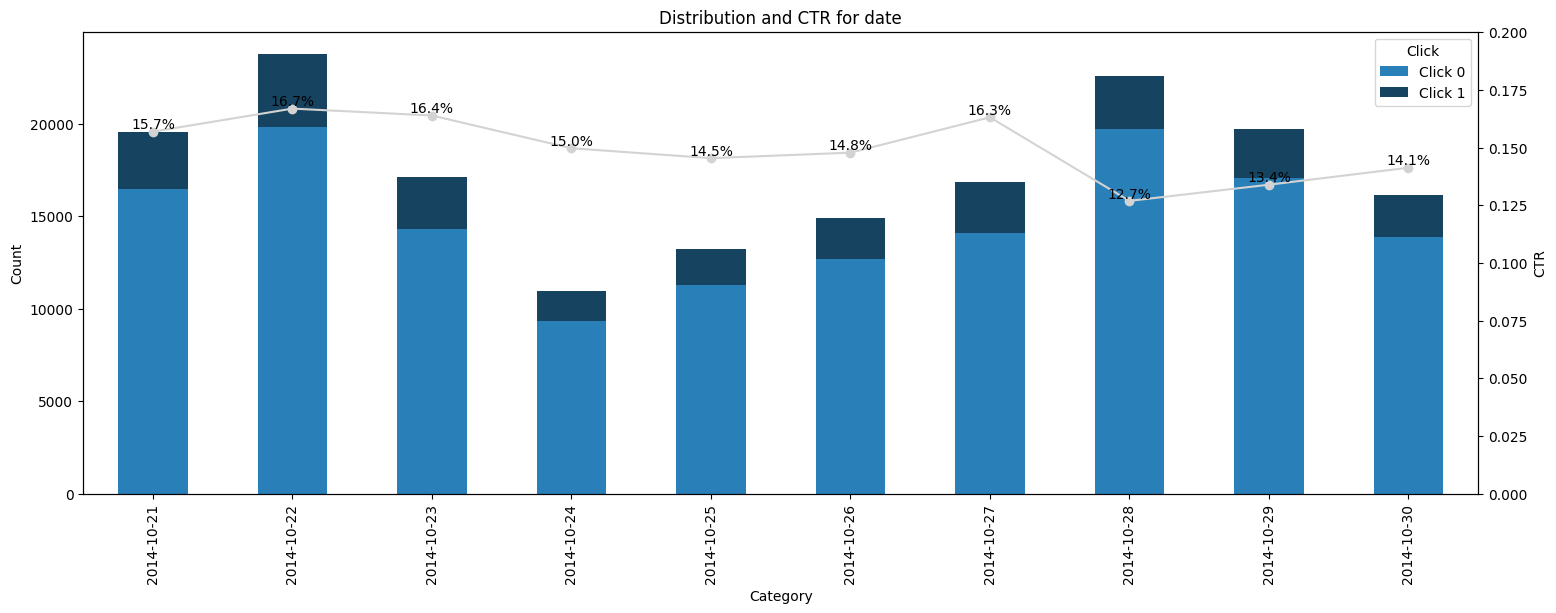


Feature: date
Category: 2014-10-21, Rows: 19531, Clicks: 3064, CTR: 15.69%
Category: 2014-10-22, Rows: 23785, Clicks: 3969, CTR: 16.69%
Category: 2014-10-23, Rows: 17123, Clicks: 2806, CTR: 16.39%
Category: 2014-10-24, Rows: 10949, Clicks: 1639, CTR: 14.97%
Category: 2014-10-25, Rows: 13220, Clicks: 1922, CTR: 14.54%
Category: 2014-10-26, Rows: 14875, Clicks: 2198, CTR: 14.78%
Category: 2014-10-27, Rows: 16855, Clicks: 2749, CTR: 16.31%
Category: 2014-10-28, Rows: 22558, Clicks: 2862, CTR: 12.69%
Category: 2014-10-29, Rows: 19712, Clicks: 2639, CTR: 13.39%
Category: 2014-10-30, Rows: 16150, Clicks: 2281, CTR: 14.12%


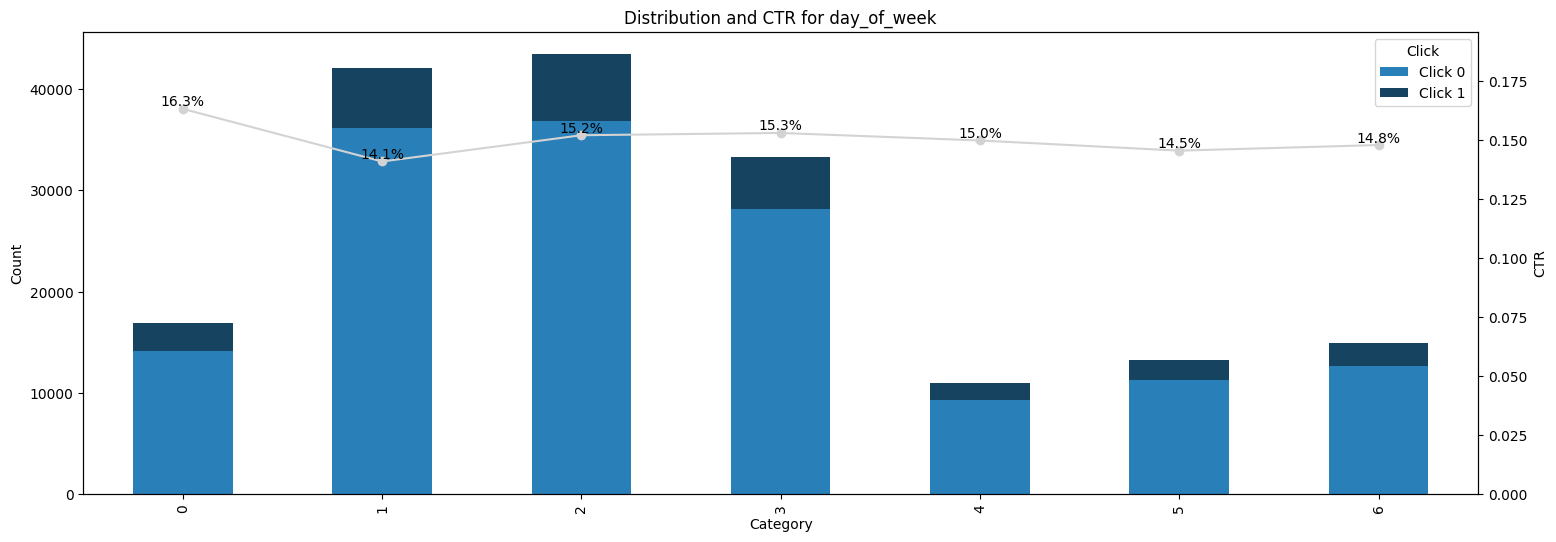


Feature: day_of_week
Category: 0, Rows: 16855, Clicks: 2749, CTR: 16.31%
Category: 1, Rows: 42089, Clicks: 5926, CTR: 14.08%
Category: 2, Rows: 43497, Clicks: 6608, CTR: 15.19%
Category: 3, Rows: 33273, Clicks: 5087, CTR: 15.29%
Category: 4, Rows: 10949, Clicks: 1639, CTR: 14.97%
Category: 5, Rows: 13220, Clicks: 1922, CTR: 14.54%
Category: 6, Rows: 14875, Clicks: 2198, CTR: 14.78%


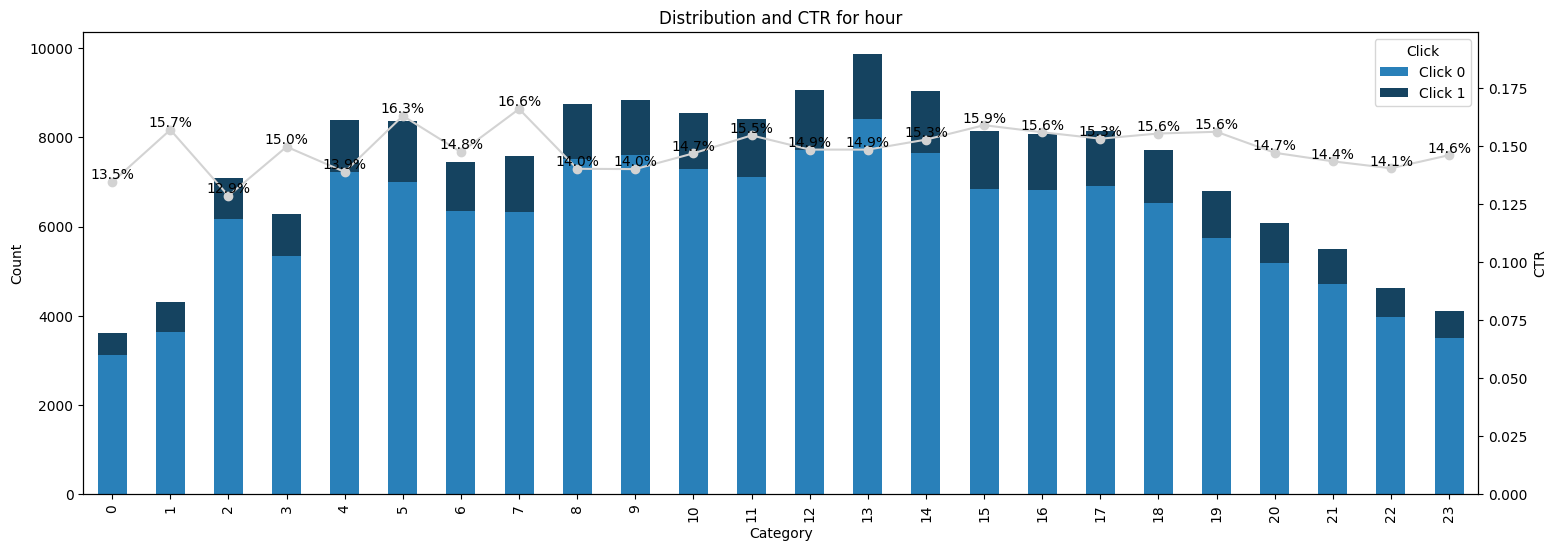


Feature: hour
Category: 0, Rows: 3611, Clicks: 486, CTR: 13.46%
Category: 1, Rows: 4301, Clicks: 676, CTR: 15.72%
Category: 2, Rows: 7079, Clicks: 911, CTR: 12.87%
Category: 3, Rows: 6273, Clicks: 940, CTR: 14.98%
Category: 4, Rows: 8382, Clicks: 1165, CTR: 13.90%
Category: 5, Rows: 8377, Clicks: 1367, CTR: 16.32%
Category: 6, Rows: 7449, Clicks: 1099, CTR: 14.75%
Category: 7, Rows: 7577, Clicks: 1259, CTR: 16.62%
Category: 8, Rows: 8750, Clicks: 1228, CTR: 14.03%
Category: 9, Rows: 8844, Clicks: 1240, CTR: 14.02%
Category: 10, Rows: 8557, Clicks: 1258, CTR: 14.70%
Category: 11, Rows: 8406, Clicks: 1301, CTR: 15.48%
Category: 12, Rows: 9056, Clicks: 1346, CTR: 14.86%
Category: 13, Rows: 9871, Clicks: 1467, CTR: 14.86%
Category: 14, Rows: 9030, Clicks: 1381, CTR: 15.29%
Category: 15, Rows: 8143, Clicks: 1296, CTR: 15.92%
Category: 16, Rows: 8071, Clicks: 1260, CTR: 15.61%
Category: 17, Rows: 8152, Clicks: 1250, CTR: 15.33%
Category: 18, Rows: 7720, Clicks: 1201, CTR: 15.56%
Category: 1

In [24]:
import matplotlib.pyplot as plt

# Features to plot
features_to_plot = ['date', 'day_of_week', 'hour']

# Iterate over each feature
for feature in features_to_plot:
    # Compute the contingency table
    contingency_table = pd.crosstab(df[feature], df['click'])

    # Calculate total ad impressions for each category
    total_ad_impressions = contingency_table.sum(axis=1)

    # Sort the contingency table by index (category) in ascending order
    contingency_table_sorted = contingency_table.sort_index()

    # Calculate CTR for each category using the sorted contingency table
    total_clicks = contingency_table_sorted[1]
    ctr = total_clicks / total_ad_impressions.loc[contingency_table_sorted.index]

    # Plot the bar chart
    fig, ax1 = plt.subplots(figsize=(18, 6))  # Adjust the figsize for wider plots
    contingency_table_sorted.plot(kind='bar', stacked=True, ax=ax1, color=['#2980B9', '#154360'])
    plt.title(f"Distribution and CTR for {feature}")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.legend(title='Click', labels=['Click 0', 'Click 1'], loc='upper right')

    # Create a line plot for percentages
    ax2 = ax1.twinx()
    ax2.plot(range(len(ctr)), ctr, marker='o', color='lightgray', label='CTR')

    # Annotate line plot with percentages rounded to one decimal place
    for i, val in enumerate(ctr):
        ax2.text(i, val, f'{val:.1%}', ha='center', va='bottom', color='black')

    # Set the y-axis limits for the line plot
    ax2.set_ylim(0, max(ctr) * 1.2)
    ax2.set_ylabel('CTR')

    # Set the x-axis ticks to be the sorted categories
    ax1.set_xticks(range(len(contingency_table_sorted.index)))
    ax1.set_xticklabels(contingency_table_sorted.index)

    # Show the plot
    plt.show()

    # Print category, number of clicks, CTR, and number of rows for each category
    print(f"\nFeature: {feature}")
    for category, clicks, click_rate, num_rows in zip(contingency_table_sorted.index, total_clicks, ctr, total_ad_impressions.loc[contingency_table_sorted.index]):
        print(f"Category: {category}, Rows: {num_rows}, Clicks: {clicks}, CTR: {click_rate:.2%}")

#### Comment about the date, day_of_week, hour plots

* date: The ad impressions in the dataset goes from 21-10-2014 to 30-10-2014, the CTR is very stable between 15-19%
* day_of_week: CTR between days (sunday, monday, ...) vary also between 15-19%, so there is not much difference. And saturday and sunday have slightly higher CTR.
* hour: CTR among the different hours vary between 15-19% too, the slightly highest CTR occurs at 14 hours, and lowest at 21 hours.

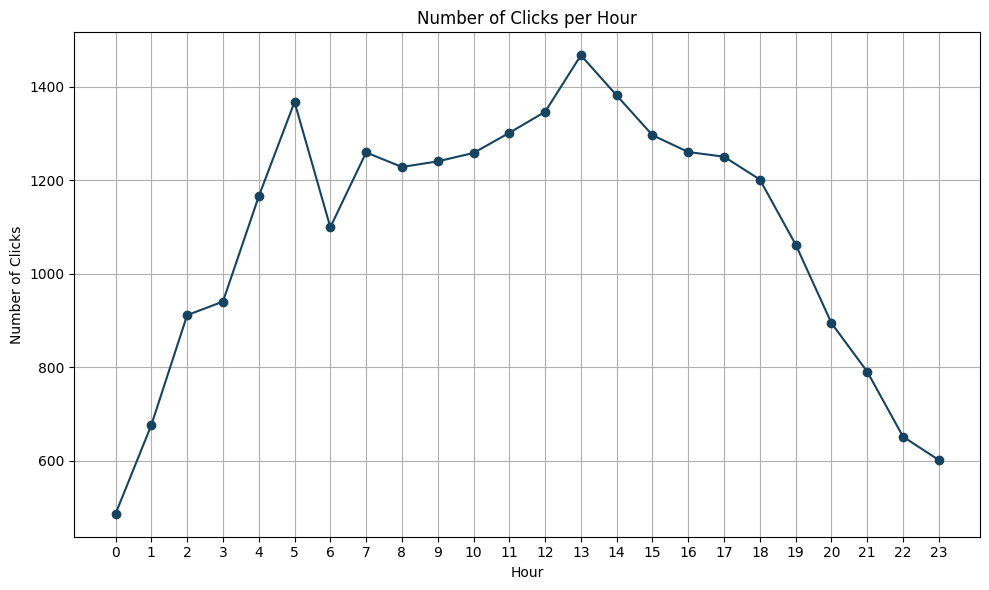

In [25]:
import matplotlib.pyplot as plt

# Grouping the DataFrame by 'hour' and counting the number of clicks per hour
clicks_per_hour = df.groupby('hour')['click'].sum()

# Plotting
plt.figure(figsize=(10, 6))
clicks_per_hour.plot(kind='line', marker='o', color='#154360')
plt.title('Number of Clicks per Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Clicks')
plt.grid(True)

# Set x ticks explicitly
plt.xticks(clicks_per_hour.index)

plt.tight_layout()
plt.show()